In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor  # VIF사용을 위한 라이브러리
from sklearn.model_selection import train_test_split # 데이터를 train과 test로 나누기 위한 라이브러리

from sklearn.preprocessing import StandardScaler # 데이터 스케일링 (표준화(Standardization))를 위한 라이브러리

import statsmodels.api as sm

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier # 의사결정나무를 위한 라이브러리
from sklearn.ensemble import RandomForestClassifier # 랜덤포레스트를 위한 라이브러리
from sklearn.ensemble import GradientBoostingClassifier # 그래디언트부스팅을 위한 라이브러리
from sklearn.svm import SVC # SVM을 위한 라이브러리
from xgboost import XGBClassifier
from xgboost import plot_importance
from scipy.stats import chi2_contingency

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [7]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 14
plt.rcParams["figure.figsize"]=(12,6)
plt.rcParams['axes.unicode_minus'] = False

print('설정되어있는 폰트 글꼴: {}'.format(plt.rcParams['font.family']))

설정되어있는 폰트 글꼴: ['Malgun Gothic']


In [8]:
import warnings

warnings.filterwarnings(action = 'ignore')

In [9]:
### 사용자 지정 함수 생성
def fun_plot_hist(data,var):
    plt.title(var)
    plt.hist(data[data['scale'] == 0][var], label = '양품', alpha = 0.5)
    plt.hist(data[data['scale'] == 1][var], label = '불량', alpha = 0.5)
    plt.legend()
    
def fun_print_cross_tab(data, var):
    print(pd.crosstab(index = data['scale'], columns = data[var]))
    print()
    print(pd.crosstab(index = data['scale'], columns = data[var], normalize='columns').round(3))

def check_difference(data, col):
    cross_tab = pd.crosstab(data["scale"], data[col])

    # 카이제곱 검정 실행
    chi2, pval, dof, expected = chi2_contingency(cross_tab)

    # 결과 출력
    print("chi-squared statistic:", chi2)
    print("p-value:", pval)
    print("degrees of freedom:", dof)
    print("expected frequencies:\n", expected)
    
#분류모델 통합 평가 : 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC
def eval_class_model(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    
    print('오차행렬:\n', confusion, '\n')
    print('정확도:{:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1    : {:.4f}'.format(F1))
    print('AUC   : {:.4f}'.format(AUC))

# 데이터 불러오기

In [10]:
df = pd.read_csv('C:/Users/HKNU/Downloads/SCALE불량.csv', encoding = 'euc-kr')
df.head()

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조
3,PLT_1004,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1152,125,1127,68,266,1127,TMCP(온도제어),885,8,1조
4,PLT_1005,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,1140,134,1128,48,246,1128,TMCP(온도제어),873,8,1조


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   plate_no         1000 non-null   object
 1   rolling_date     1000 non-null   object
 2   scale            1000 non-null   object
 3   spec_long        1000 non-null   object
 4   spec_country     1000 non-null   object
 5   steel_kind       1000 non-null   object
 6   pt_thick         1000 non-null   int64 
 7   pt_width         1000 non-null   int64 
 8   pt_length        1000 non-null   int64 
 9   hsb              1000 non-null   object
 10  fur_no           1000 non-null   object
 11  fur_input_row    1000 non-null   object
 12  fur_heat_temp    1000 non-null   int64 
 13  fur_heat_time    1000 non-null   int64 
 14  fur_soak_temp    1000 non-null   int64 
 15  fur_soak_time    1000 non-null   int64 
 16  fur_total_time   1000 non-null   int64 
 17  fur_ex_temp      1000 non-null   i

In [12]:
df.describe()

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_temp,descaling_count
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,26.78200,2831.900000,36788.200000,1157.245000,85.972000,1150.928000,71.720000,238.589000,1150.928000,934.637000,8.557000
std,18.13757,494.081478,13912.387116,21.245007,26.346297,17.344384,20.602137,38.194828,17.344384,96.598015,1.604158
min,12.00000,1800.000000,7900.000000,1103.000000,55.000000,1113.000000,35.000000,165.000000,1113.000000,0.000000,5.000000
25%,15.00000,2500.000000,26650.000000,1140.000000,66.000000,1135.750000,57.750000,210.000000,1135.750000,893.750000,8.000000
50%,19.00000,2800.000000,40400.000000,1159.000000,75.000000,1156.000000,66.000000,230.000000,1156.000000,948.000000,9.000000
75%,34.00000,3100.000000,49100.000000,1173.000000,102.250000,1164.000000,81.000000,263.000000,1164.000000,991.000000,10.000000
max,100.00000,4600.000000,54900.000000,1206.000000,158.000000,1185.000000,145.000000,362.000000,1185.000000,1078.000000,10.000000


- rolling_temp(압연온도)가 0인 이상치 존재

In [22]:
df.describe(include = 'object')

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,hsb,fur_no,fur_input_row,rolling_method,work_group,교대
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,1000,1000,2,66,7,2,2,3,2,2,4,2
top,PLT_1001,03JAN2023:07:07:53,양품,JS-SM490YB,영국,C,적용,3호기,1열,CR(제어압연),2조,2교대
freq,1,1,690,84,256,755,953,342,508,840,292,502


In [23]:
df['scale'].value_counts()

양품    690
불량    310
Name: scale, dtype: int64

In [24]:
df.columns

Index(['plate_no', 'rolling_date', 'scale', 'spec_long', 'spec_country',
       'steel_kind', 'pt_thick', 'pt_width', 'pt_length', 'hsb', 'fur_no',
       'fur_input_row', 'fur_heat_temp', 'fur_heat_time', 'fur_soak_temp',
       'fur_soak_time', 'fur_total_time', 'fur_ex_temp', 'rolling_method',
       'rolling_temp', 'descaling_count', 'work_group', '교대'],
      dtype='object')

In [25]:
### 전처리 전에 근무 조마다 특정 교대 시간이 있다고 가정하고 파악
for group in df.work_group.unique().tolist():
    print(group, list(set([x.split(':')[1] for x in df[df.work_group==group]['rolling_date'].tolist()])))

1조 ['07', '09', '17', '08', '14', '11', '12', '13', '15', '10', '16', '18']
2조 ['05', '04', '02', '03', '20', '01', '00', '22', '06', '23', '19', '21']
3조 ['07', '09', '17', '08', '14', '11', '12', '13', '15', '10', '16', '18']
4조 ['05', '04', '02', '03', '20', '01', '00', '22', '06', '23', '19', '21']


In [26]:
### 근무시간 별 추가 컬럼 생성
df['교대'] = df.rolling_date.apply(lambda x: '1교대' if x.split(':')[1] in ['07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18'] else '2교대')
df.head()

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group,교대
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,116,1133,59,259,1133,TMCP(온도제어),934,8,1조,1교대
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,122,1135,53,238,1135,TMCP(온도제어),937,8,1조,1교대
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,116,1121,55,258,1121,TMCP(온도제어),889,8,1조,1교대
3,PLT_1004,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,125,1127,68,266,1127,TMCP(온도제어),885,8,1조,1교대
4,PLT_1005,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,134,1128,48,246,1128,TMCP(온도제어),873,8,1조,1교대


# EDA(Exploratory Data Analysis)

<AxesSubplot:title={'center':'상관계수행렬 히트맵'}>

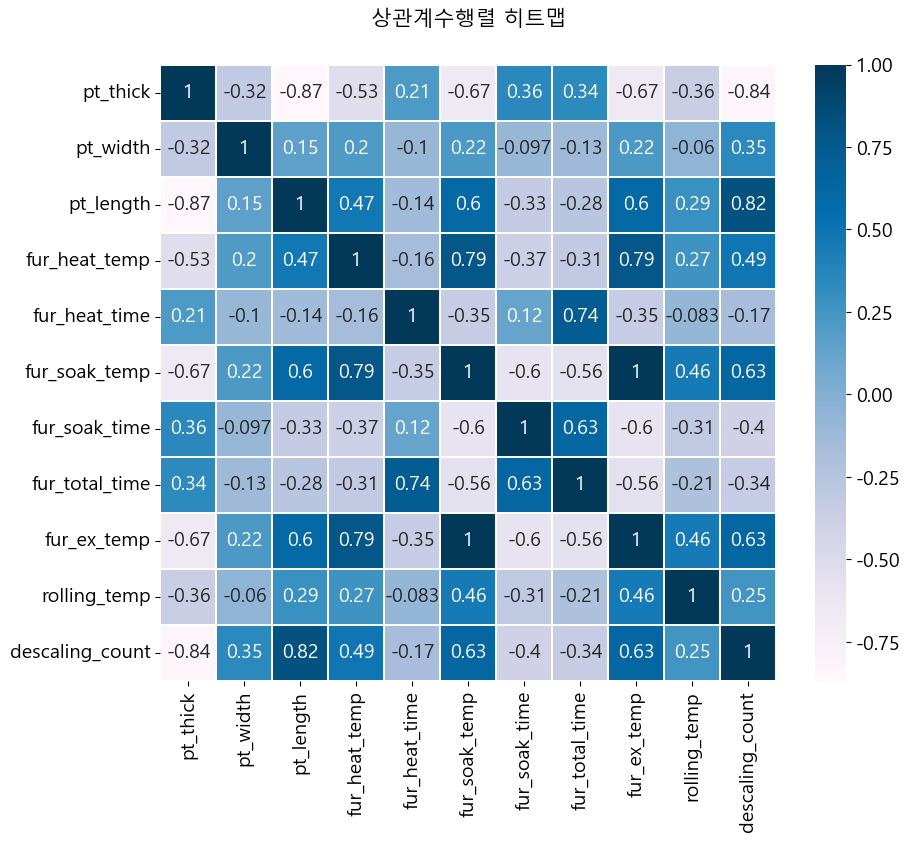

In [27]:
# 상관계수행렬
cor_df = df.corr().round(3)

colormap = plt.cm.PuBu
plt.figure(figsize=(10, 8))
plt.title("상관계수행렬 히트맵", y = 1.05, size = 15)
sns.heatmap(cor_df, linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True)

- pt_thick, pt_length와 강한 음의 상관관계를 보임


- descaling_counts, pt_length와 0.82로 강한 양의 상관관계를 보임


- fur_heat_temp와 fur_ex_temp는 0.79로 강한 양의 상관관계를 보임


- fur_soak_temp와 fur_heat_temp는 0.79로 강한 양의 상관관계를 보임


- fur_heat_time과 fur_total_time은 0.74로 강한 양의 상관관계를 보임


- descaling_count와 pt_thick은 -0.85로 강한 음의 상관관계를 보임


- 따라서, 이상치 처리 검토 및 적절한 설명변수 선택이 필요하며 설명변수 간 다중공선성 처리가 필요

array([[<AxesSubplot:title={'center':'pt_thick'}>,
        <AxesSubplot:title={'center':'pt_width'}>,
        <AxesSubplot:title={'center':'pt_length'}>],
       [<AxesSubplot:title={'center':'fur_heat_temp'}>,
        <AxesSubplot:title={'center':'fur_heat_time'}>,
        <AxesSubplot:title={'center':'fur_soak_temp'}>],
       [<AxesSubplot:title={'center':'fur_soak_time'}>,
        <AxesSubplot:title={'center':'fur_total_time'}>,
        <AxesSubplot:title={'center':'fur_ex_temp'}>],
       [<AxesSubplot:title={'center':'rolling_temp'}>,
        <AxesSubplot:title={'center':'descaling_count'}>, <AxesSubplot:>]],
      dtype=object)

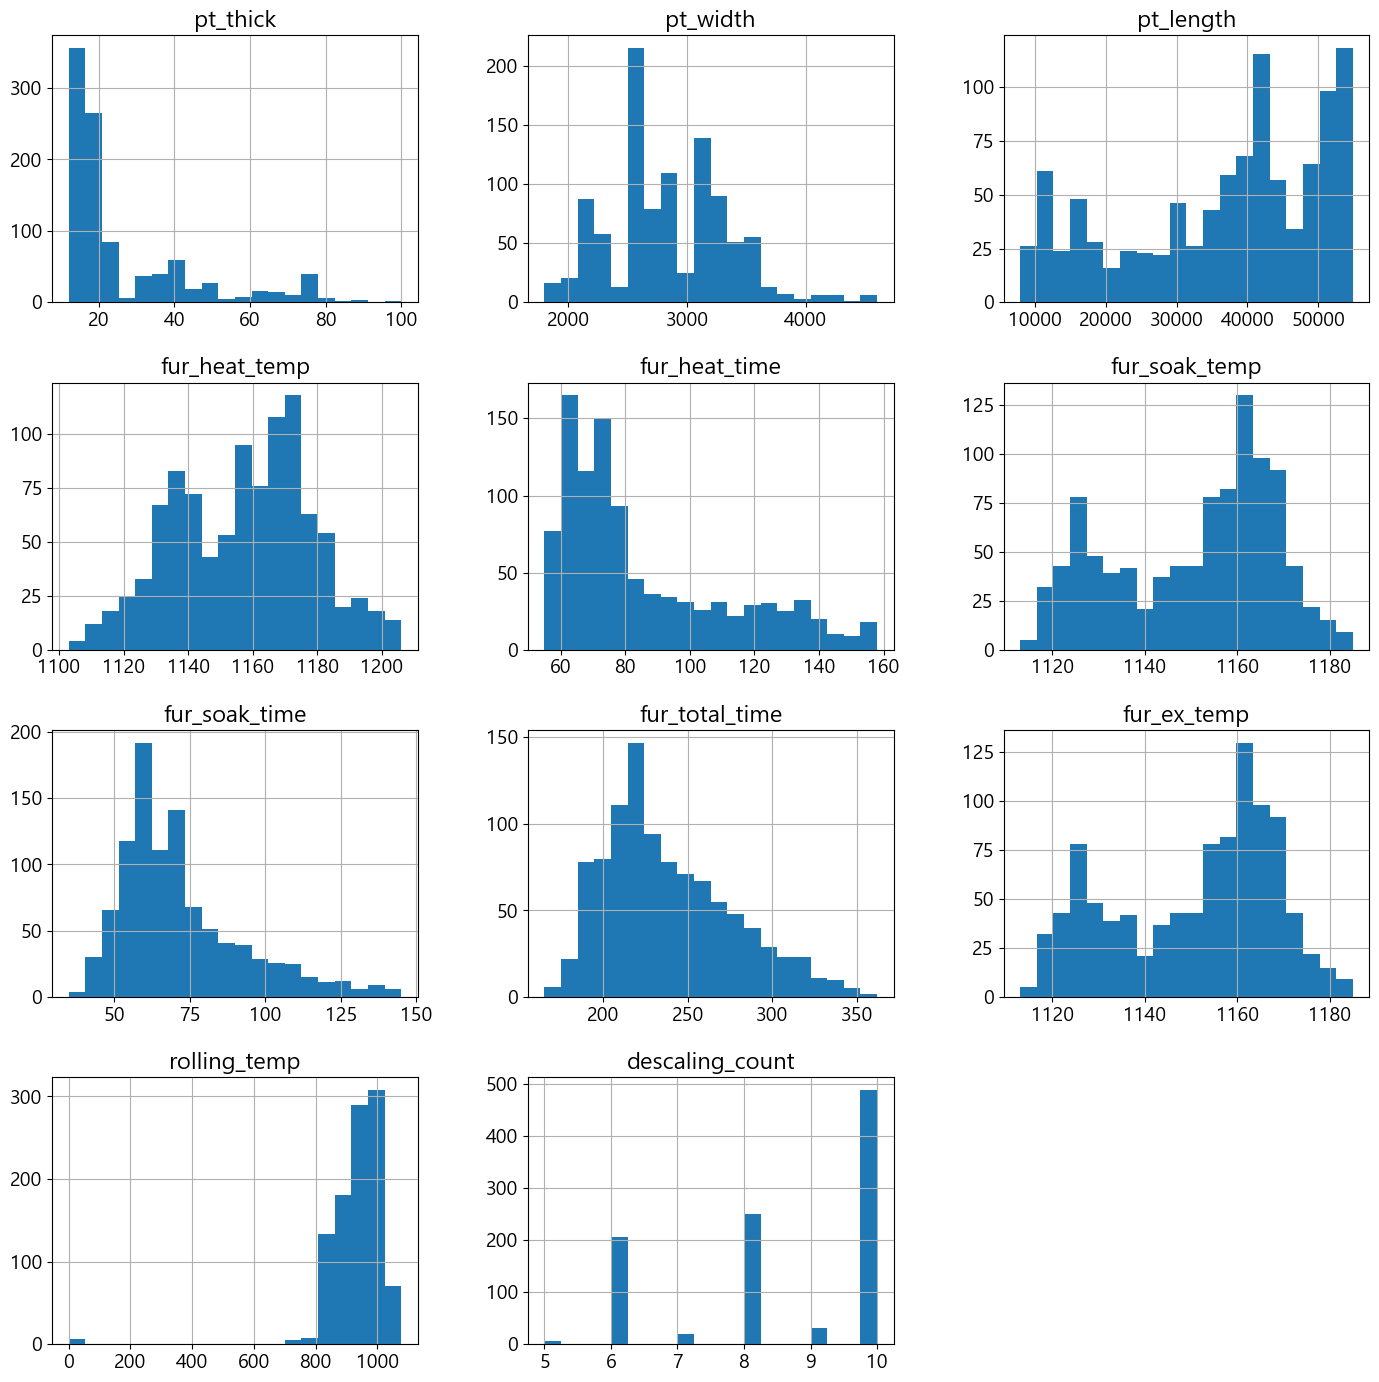

In [28]:
# 연속형 변수 히스토그램
df.hist(figsize = (17,17), bins = 20)

- pt_thick의 경우, 주로 10 ~ 20mm에 분포함
- pt_width의 경우 2500~2600mm에 주로 분포함
- pt_length의 경우, 4만~5만 사이에 주로 분포함
- fur_heat_temp의 경우, 1160~1180에 주로 분포함
- fur_heat_time의 경우, 60~80에 주로 분포함
- fur_soak_temp의 경우, 1150~1180에 주로 분포함
- fur_soak_time의 경우, 50~75에 주로 분포함
- fur_total_time의 경우, 200~240에 주로 분포함
- fur_ex_temp의 경우, 1160~1170에 분포함
- rolling_temp의 경우, 800~1000에 분포함
- descaling_count의 경우, 10이 가장 높은 것을 확인할 수 있음

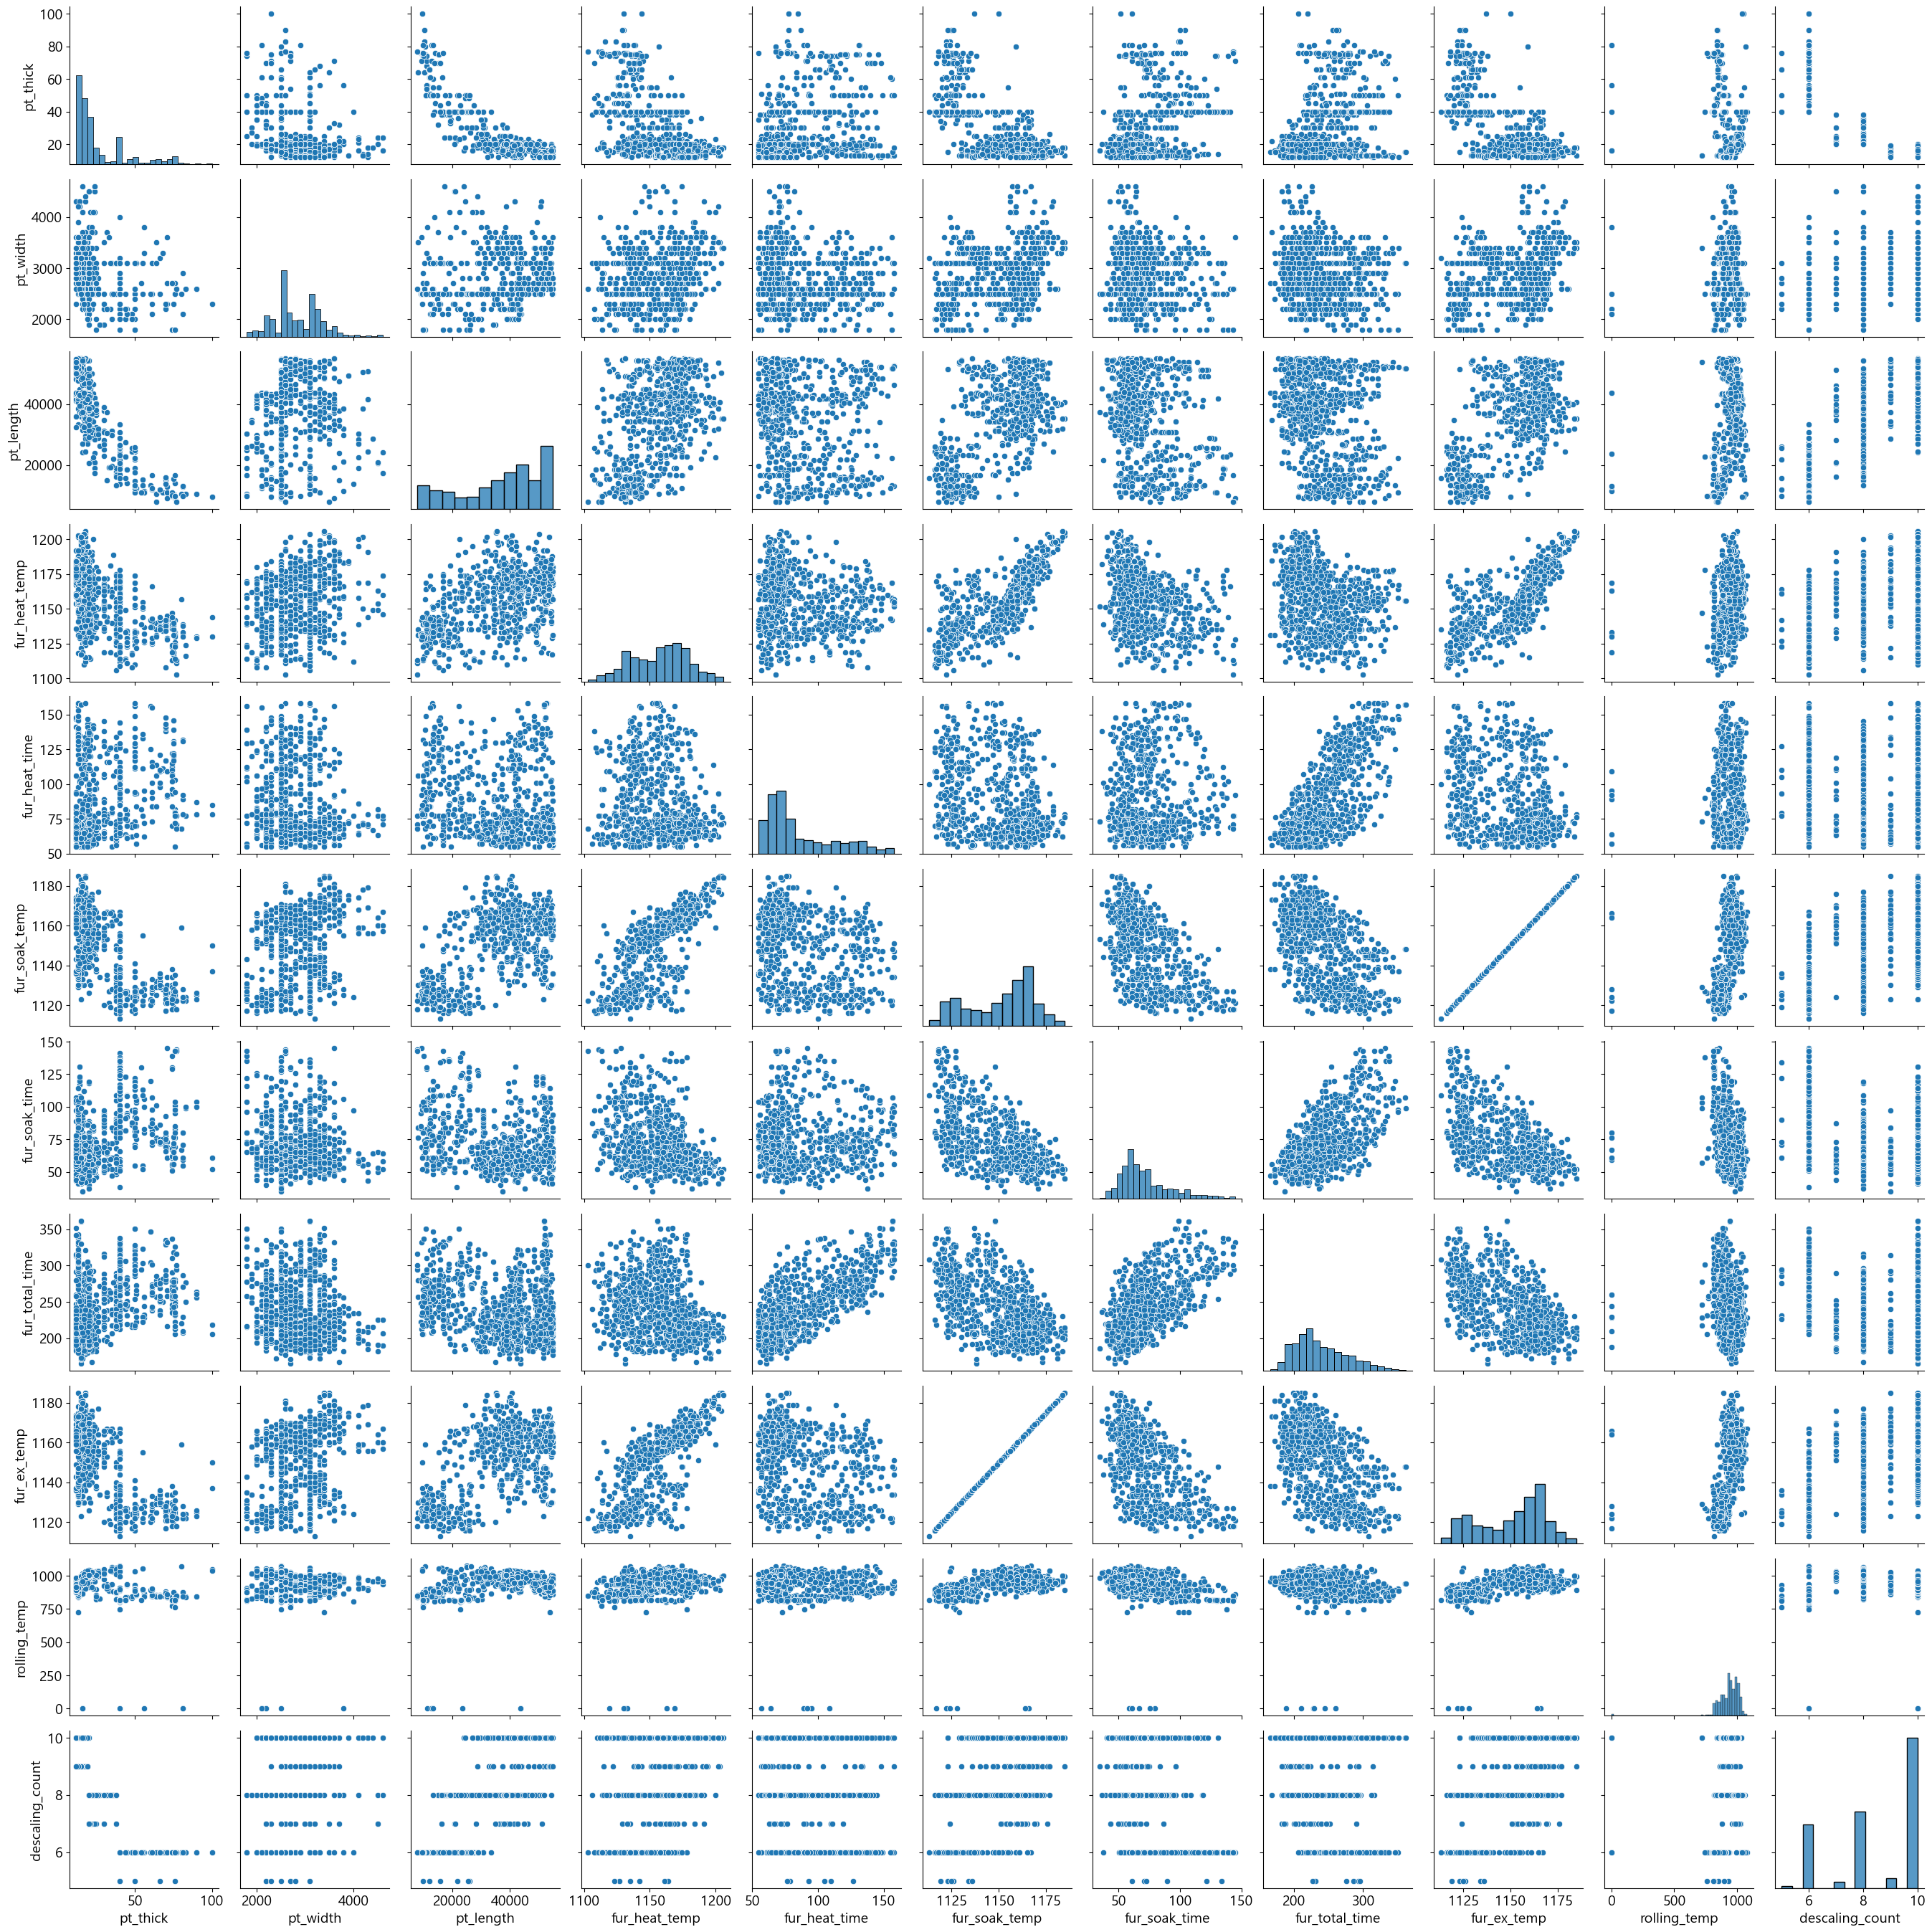

In [29]:
# 산점도
sns.pairplot(df)

In [30]:
# 범주형 변수의 카테고리별 빈도 출력
col = df.drop(['plate_no', 'rolling_date'], axis = 1)
for col in col:
    print(col)
    fun_print_cross_tab(df, col)
    print()

scale
scale   불량   양품
scale          
불량     310    0
양품       0  690

scale   불량   양품
scale          
불량     1.0  0.0
양품     0.0  1.0

spec_long
spec_long  A131-DH36TM  A283-C  A516-60  A709-36  AB/A  AB/AH32  AB/B  \
scale                                                                   
불량                   1       5        2        0    13        8     3   
양품                   0       1        1        1    38       23     6   

spec_long  AB/EH32-TM  AB/EH36-TM  API-2W-50T  ...  NV-A32-TM  NV-A36-TM  \
scale                                          ...                         
불량                  0           2           0  ...          1          0   
양품                  2          30           2  ...          2          2   

spec_long  NV-B  NV-D32-TM  NV-D36-TM  NV-E32-TM  NV-E36-TM  PILAC-BT33  \
scale                                                                     
불량            2          0          1          0          0           2   
양품            1          4     

fur_heat_time  55   56   57   58   59   60   61   62   63   64   ...  145  \
scale                                                            ...        
불량               7    2    4    4    4    3    7    6   11    5  ...    1   
양품               8    8   10    8    7   12   25   21   28   22  ...    0   

fur_heat_time  146  147  148  149  153  155  156  157  158  
scale                                                       
불량               0    1    2    0    0    0    0    0    1  
양품               2    2    5    2    2    1    5    3    6  

[2 rows x 100 columns]

fur_heat_time    55   56     57     58     59   60     61     62     63   \
scale                                                                      
불량             0.467  0.2  0.286  0.333  0.364  0.2  0.219  0.222  0.282   
양품             0.533  0.8  0.714  0.667  0.636  0.8  0.781  0.778  0.718   

fur_heat_time    64   ...  145  146    147    148  149  153  155  156  157  \
scale                 ...              

- 국가별 불량률 확인시, 일본과 한국의 비율이 상당함을 알 수 있음 (일본 - 51.9%, 한국 - 37.1%)
- 강종별 불량률 확인시, 탄소는 38.4%, 티타늄은 8.2%의 불량률을 보임
- hsb 적용에 대한 불량률 확인시, 미적용시 100%의 불량률, 적용시 27.6%의 불량률을 보임
- 3호기의 불량률은 34.2%로, 셋 중에서 가장 불량률이 높음
- 제어압연의 불량률은 35.4%로, 온도제어보다 더 높음 -> 온도를 제어하기 보다 압연관련제어를 더 잘해야 불량률을 줄일 수 있지 않을까?
- 1열은 32.5%, 2열은 29.5%이고, 3호기 1열이 가장 불량률이 높음을 판단할 수 있음
- 2조, 4조의 성적이 좋고, 1, 3조의 성적이 저조한 것을 알 수 있음
- 교대를 했을 때, 1교대를 했을 때의 성적이 저조한 것을 알 수 있음

In [31]:
df.columns

Index(['plate_no', 'rolling_date', 'scale', 'spec_long', 'spec_country',
       'steel_kind', 'pt_thick', 'pt_width', 'pt_length', 'hsb', 'fur_no',
       'fur_input_row', 'fur_heat_temp', 'fur_heat_time', 'fur_soak_temp',
       'fur_soak_time', 'fur_total_time', 'fur_ex_temp', 'rolling_method',
       'rolling_temp', 'descaling_count', 'work_group', '교대'],
      dtype='object')

### 1. 강종과 불량률 비교

<AxesSubplot:>

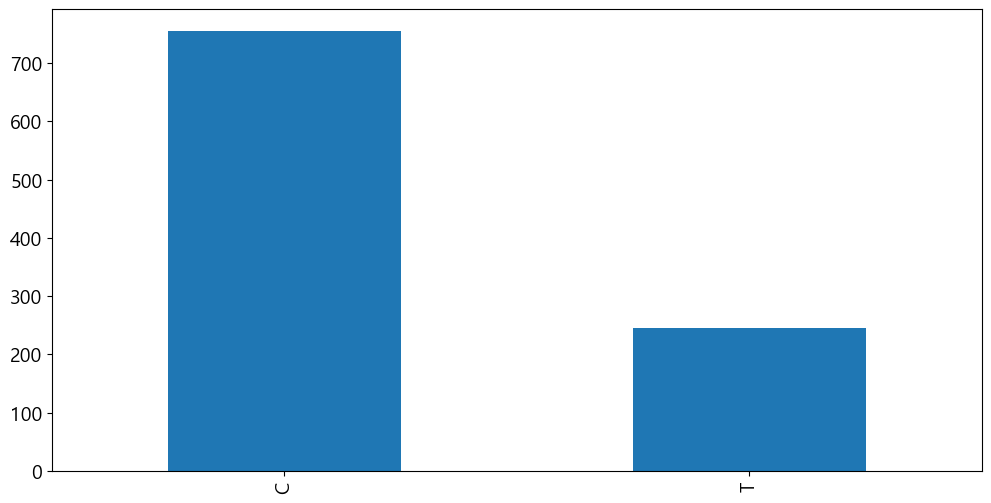

In [32]:
df_agg = df["steel_kind"].value_counts()
df_agg.sort_index(inplace = True)
df_agg.plot.bar()

- 탄소의 비율이 티타늄보다 높은 것으로 보아, 탄소가 더 많이 쓰임을 알 수 있다.

In [33]:
df_groups = df.groupby(["steel_kind"])["scale"]
df_w = pd.DataFrame(columns = ["steel_kind", "scale_prob"])
c = 0.0
for name, g in df_groups:
    c += g.tolist().count(1)/(g.shape[0])
    df_w = df_w.append({"steel_kind" : name , "scale_prob" : (g.tolist().count(1)/(g.shape[0])) * 100}, ignore_index = True )
df_w

,steel_kind,scale_prob
0,C,0.0
1,T,0.0


- 불량률을 계산하여 강종과 연결지었는데, 둘다 관련이 없는 것으로 나왔다.

In [34]:
df["spec_name"] = df.spec_long.str.split("-").str[0]
df["spec_name"].value_counts()

JS         154
LR         151
BV         141
NV         105
GL          87
KR          58
AB/A        51
PILAC       40
COMMON      36
NK          33
AB/EH36     32
AB/AH32     31
KS          30
SA283       21
AB/B         9
A283         6
V42JBN3      4
A516         3
API          2
CCS          2
AB/EH32      2
A709         1
A131         1
Name: spec_name, dtype: int64

- 규격 이름만 뽑기 위해 -를 기준으로 분리하였고, JS가 가장 많음


- 선급협회별로 분류


- 선급 : 선박의 선급을 매기거너 선박의 손상 따위를 사정하는 것

In [35]:
df['spec_long'].value_counts()

JS-SM490YB     84
LR-A           81
LR-AH32        52
AB/A           51
NV-A           48
               ..
LR-AH36         1
BV-AH36-TM      1
A131-DH36TM     1
KR-B            1
KS-HSB600       1
Name: spec_long, Length: 66, dtype: int64

- JS-SM490YB, LR-A가 가장 많이 쓰임

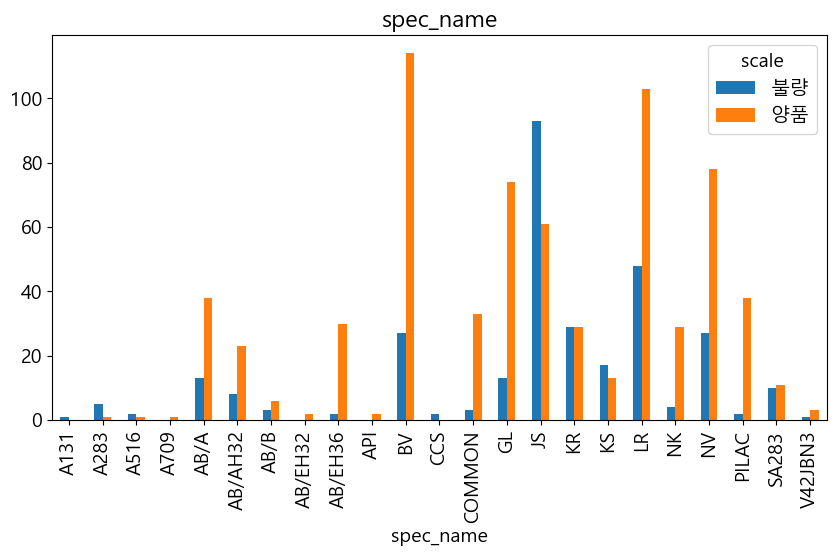

In [36]:
df_spec_name_eda = df.groupby(["spec_name",'scale'])['scale'].count().unstack('scale')
df_spec_name_eda.plot(kind='bar', figsize=(10,5))
plt.title('spec_name')
plt.show()

- 규격에 따른 불량률을 알아보고자 그래프를 그려보았을 때, JS가 가장 많이 쓰였는데 JS의 불량률이 가장 높았다.
- BV, LR, NV, GL 같은 경우는 양품의 비율이 높았다.

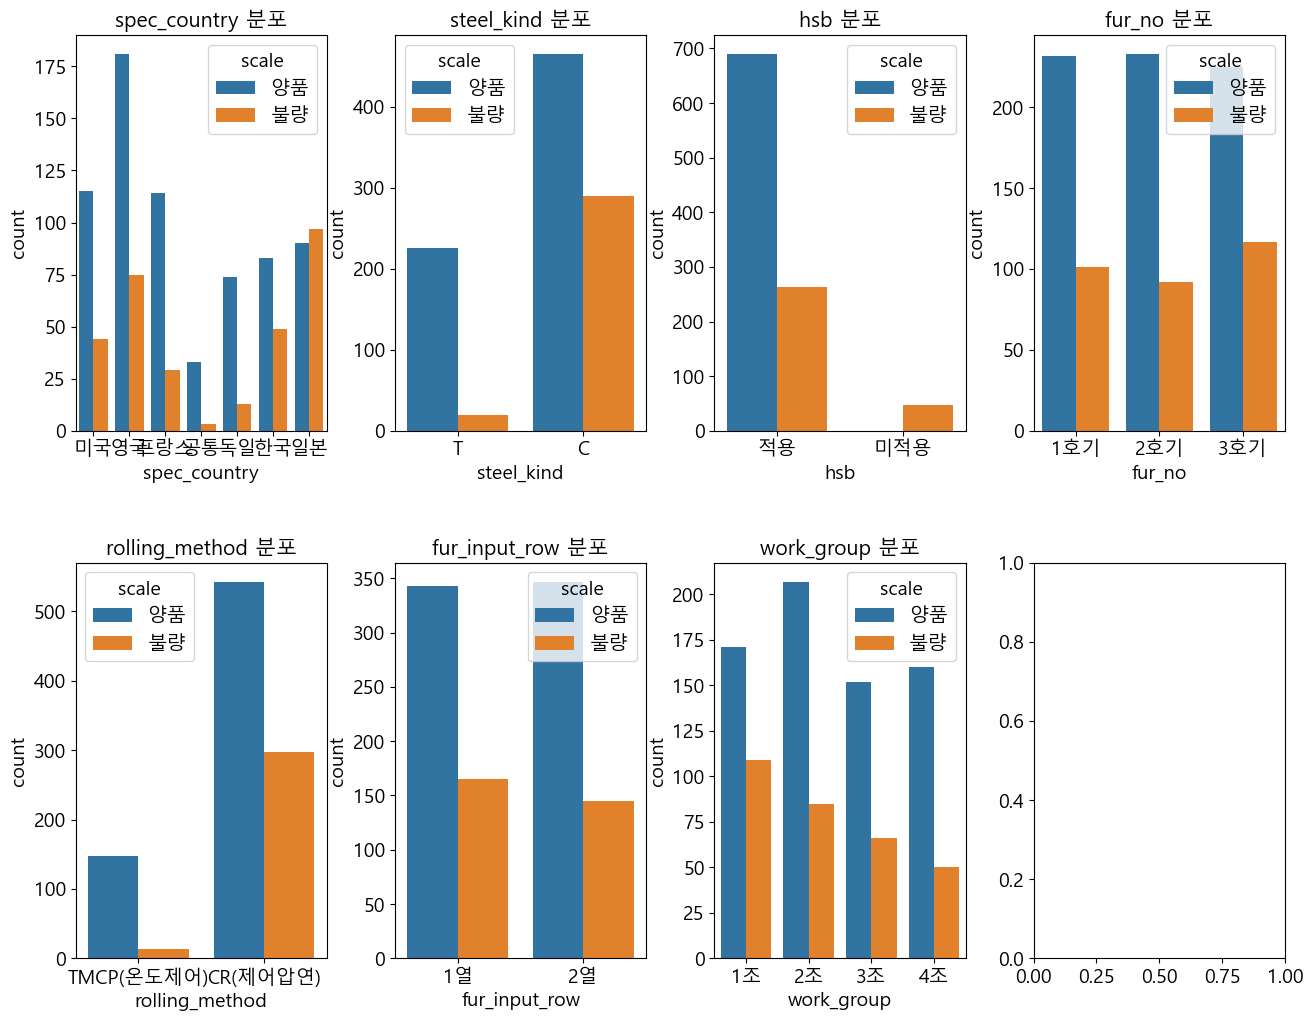

In [37]:
## 전체 범주형 변수들의 분포 확인
cols = ['spec_country', 'steel_kind', 'hsb', 'fur_no', 'rolling_method', 'fur_input_row', 'work_group']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(13,10))
plt.tight_layout(w_pad=1, h_pad=5)
i = 1
for col in cols:
    plt.subplot(2, 4, i) 
    sns.countplot(data=df, x=col, hue='scale')
    plt.title(col + " 분포", fontsize=15)
    i += 1

- 일본의 불량률이 제일 높다.
- 탄소가 티타늄이 많이 쓰이는데, 탄소의 불량률이 더 높다.
- hsb를 적용하지 않았을 때, 100%의 불량률을 보인다.
- 다른 호기보다 3호기의 불량률이 높다.
- 제어압연을 하였을ㅁ 때의 불량률이 비교적으로 높다.
- 2열보다 1열의 불량률이 더 높고, 정리하자면 3호기 1열의 불량률이 더 높은 것을 알 수 있다.
- 2조, 4조의 양품률이 높고, 1조, 3조의 불량률이 가장 높은 것을 알 수 있다.
- 따라서 3, 4조의 성적이 제일 좋은 것으로 판단된다.

호열     1호기1열  1호기2열  2호기1열  2호기2열  3호기1열  3호기2열
scale                                          
불량        57     44     48     44     60     57
양품       101    131    124    109    118    107

호열     1호기1열  1호기2열  2호기1열  2호기2열  3호기1열  3호기2열
scale                                          
불량     0.361  0.251  0.279  0.288  0.337  0.348
양품     0.639  0.749  0.721  0.712  0.663  0.652


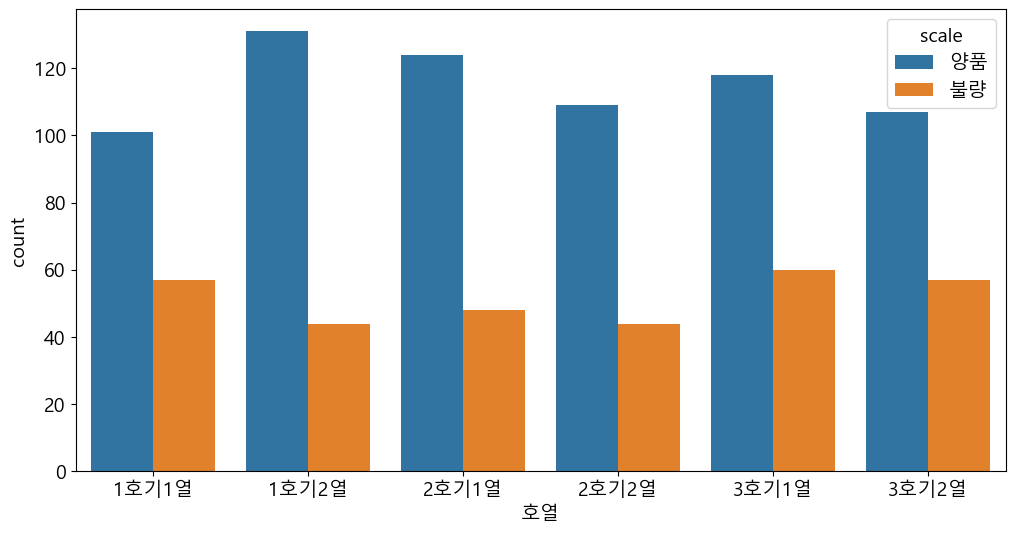

In [38]:
df['호열'] = df.fur_no + df.fur_input_row
sns.countplot(data=df, x='호열', hue='scale')
fun_print_cross_tab(df,'호열')

[Text(0, 0, 'AB/EH32-TM'),
 Text(1, 0, 'NV-E36-TM'),
 Text(2, 0, 'BV-EH36-TM'),
 Text(3, 0, 'AB/EH36-TM'),
 Text(4, 0, 'COMMON'),
 Text(5, 0, 'BV-AH32-TM'),
 Text(6, 0, 'GL-E32-TM'),
 Text(7, 0, 'GL-E36-TM'),
 Text(8, 0, 'BV-EH32-TM'),
 Text(9, 0, 'KS-HSB600'),
 Text(10, 0, 'LR-EH36-TM'),
 Text(11, 0, 'BV-B'),
 Text(12, 0, 'AB/B'),
 Text(13, 0, 'LR-B'),
 Text(14, 0, 'JS-SM490YB'),
 Text(15, 0, 'KR-B'),
 Text(16, 0, 'LR-A'),
 Text(17, 0, 'JS-SM490A'),
 Text(18, 0, 'KS-SM400B'),
 Text(19, 0, 'JS-SM400B'),
 Text(20, 0, 'KS-SS400'),
 Text(21, 0, 'KR-A'),
 Text(22, 0, 'JS-SS400'),
 Text(23, 0, 'NV-A'),
 Text(24, 0, 'KS-SM400A'),
 Text(25, 0, 'KS-SM490B'),
 Text(26, 0, 'V42JBN3'),
 Text(27, 0, 'AB/A'),
 Text(28, 0, 'A516-60'),
 Text(29, 0, 'BV-AH32'),
 Text(30, 0, 'JS-SM490YA'),
 Text(31, 0, 'AB/AH32'),
 Text(32, 0, 'GL-A32'),
 Text(33, 0, 'LR-AH32'),
 Text(34, 0, 'CCS-B'),
 Text(35, 0, 'NV-B'),
 Text(36, 0, 'NV-A32'),
 Text(37, 0, 'KS-SM490A'),
 Text(38, 0, 'GL-A'),
 Text(39, 0, 'NK-KA32'),

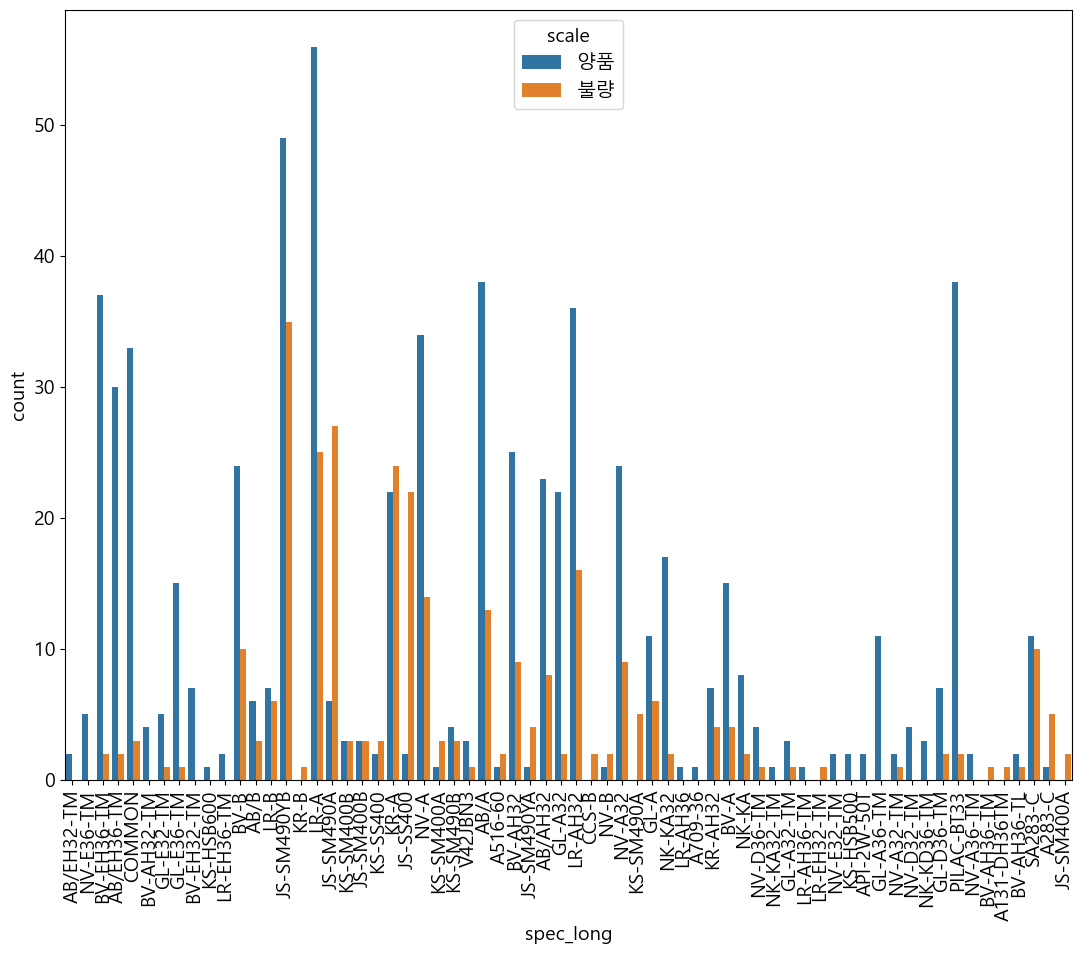

In [39]:
### 규격별 불량률 확인
fig, axes = plt.subplots(figsize=(13,10))
sns.countplot(data = df, x='spec_long', hue='scale')
axes.set_xticklabels(axes.get_xticklabels(),rotation = 90)
# fun_plot_hist(df, 'spec_long')

In [40]:
### 국가 규격별 유의미한 차이 있는지 검정
### 일본의 불량률이 현저하게 차이가 있다고 판단해서 근거 파악
check_difference(df,'spec_country')

chi-squared statistic: 68.38385440143149
p-value: 8.766804557877507e-13
degrees of freedom: 6
expected frequencies:
 [[ 11.16  26.97  49.29  79.36  57.97  44.33  40.92]
 [ 24.84  60.03 109.71 176.64 129.03  98.67  91.08]]


- 국가별 불량률에 대한 유의미한 차이가 있음

In [41]:
### 강종별 유의미한 차이가 있는지 검정
check_difference(df,'steel_kind')

chi-squared statistic: 77.7104243330205
p-value: 1.1931000837493562e-18
degrees of freedom: 1
expected frequencies:
 [[234.05  75.95]
 [520.95 169.05]]


- 강종별 유의미한 차이가 있음

In [42]:
### HSB 적용 유무에 유의미한 차이가 있는지 검정
### 그래프 상으로도 분명한 차이가 있는지 확인했음
check_difference(df,'hsb')

chi-squared statistic: 106.4133937362546
p-value: 5.985184936341528e-25
degrees of freedom: 1
expected frequencies:
 [[ 14.57 295.43]
 [ 32.43 657.57]]


- HSB 적용 유무에 대한 유의미한 차이가 있음을 알 수 있다.

In [43]:
### 호열 컬럼에 호기와 열에 관한 데이터를 합병했기 때문에 해당 컬럼으로 확인 예정
check_difference(df, '호열')

chi-squared statistic: 7.530559146463181
p-value: 0.18407582444483786
degrees of freedom: 5
expected frequencies:
 [[ 48.98  54.25  53.32  47.43  55.18  50.84]
 [109.02 120.75 118.68 105.57 122.82 113.16]]


- 호열별로 유의미한 차이가 있음을 알 수 있다.

In [44]:
### rolling_method(압연 방식)에 따른 유의미한 차이가 있는지 검정
check_difference(df, 'rolling_method')

chi-squared statistic: 45.33194472272312
p-value: 1.6631417719483292e-11
degrees of freedom: 1
expected frequencies:
 [[260.4  49.6]
 [579.6 110.4]]


- 압연 방식에 따른 유의미한 차이가 있음을 알 수 있다.

In [45]:
### 근무조 및 교대에 있어서 유의미한 차이가 있는지 검정
check_difference(df,'work_group')

chi-squared statistic: 13.84622170632565
p-value: 0.0031221225267359233
degrees of freedom: 3
expected frequencies:
 [[ 86.8   90.52  67.58  65.1 ]
 [193.2  201.48 150.42 144.9 ]]


- 근무조 및 교대에 있어서 유의미한 차이가 없음을 알 수 있다.

In [46]:
df_japan = df[df.spec_country=='일본']
df_japan.reset_index(drop=True, inplace=True)
df_japan.shape

(187, 25)

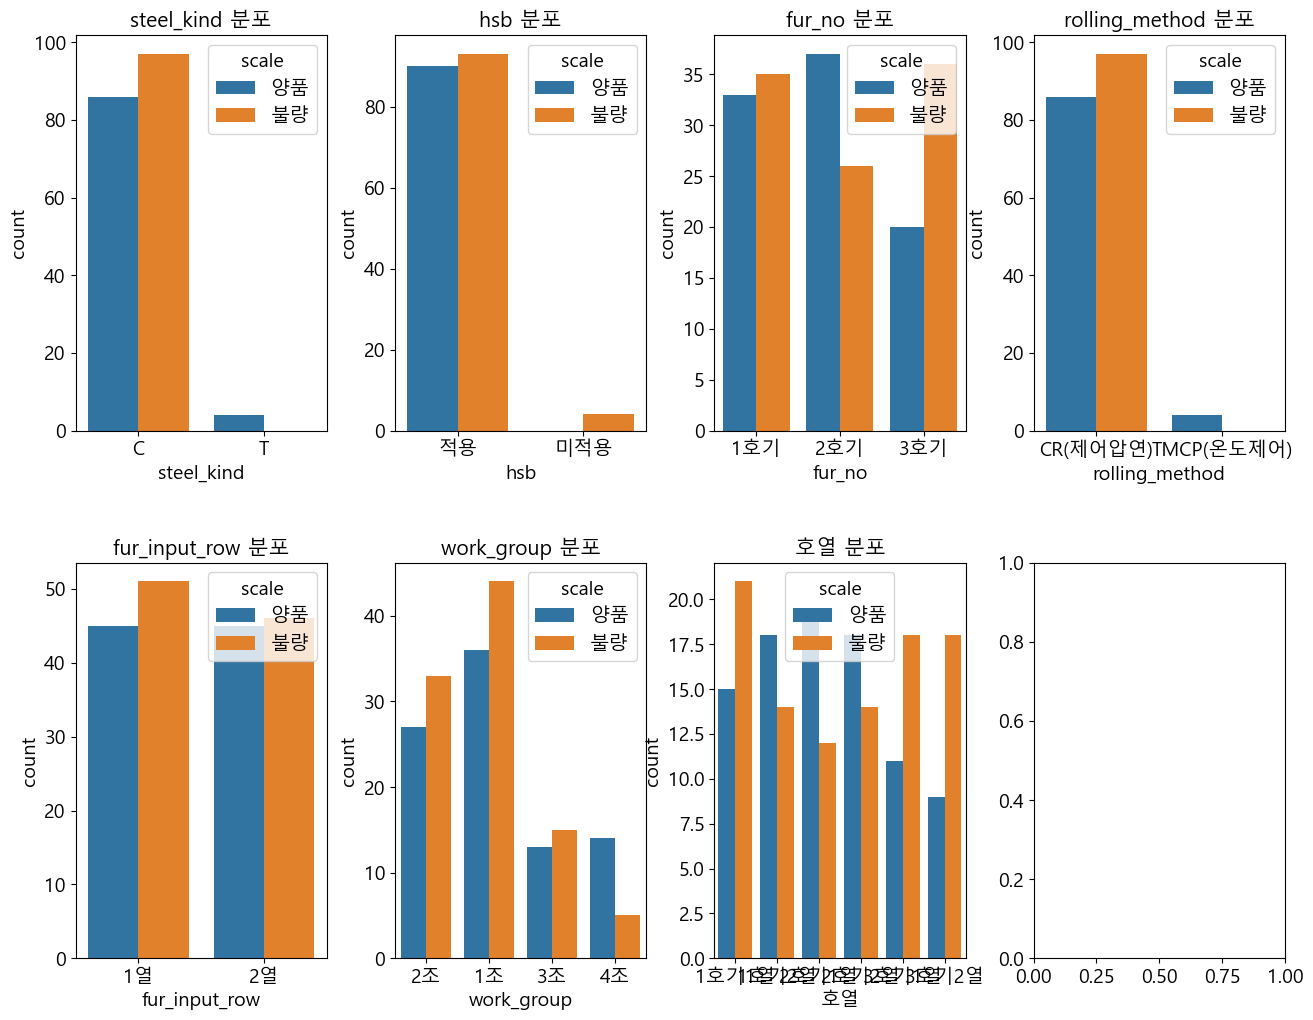

In [47]:
## 전체 범주형 변수들의 분포 확인
cols = ['steel_kind', 'hsb', 'fur_no', 'rolling_method', 'fur_input_row', 'work_group',
       '호열']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(13,10))
plt.tight_layout(w_pad=1, h_pad=5)
i = 1
for col in cols:
    plt.subplot(2, 4, i) 
    sns.countplot(data=df_japan, x=col, hue='scale')
    plt.title(col + " 분포", fontsize=15)
    i += 1

In [48]:
### 각 범주별 유의미한 차이 있는지 파악
for col in cols:
    cross_tab = pd.crosstab(df_japan["scale"], df_japan[col])

    # 카이제곱 검정 실행
    chi2, pval, dof, expected = chi2_contingency(cross_tab)
    if pval < 0.05:
        print('{}은 유의미한 차이가 있다'.format(col))

fur_no은 유의미한 차이가 있다


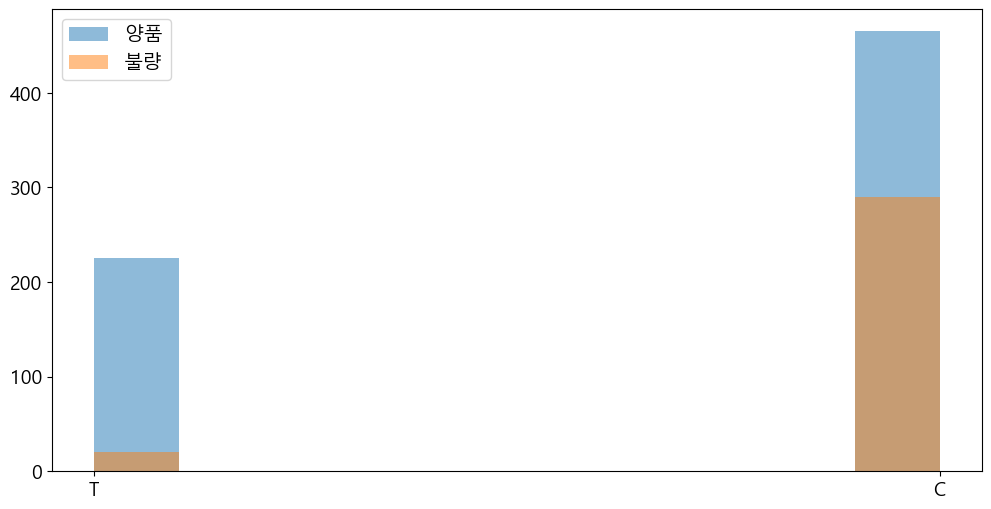

In [49]:
def fun_plot_hist(data, var):
    plt.hist(data[data["scale"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["scale"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.legend()
fun_plot_hist(df, "steel_kind")

 - 탄소가 티타늄보다 불량이 더 많음

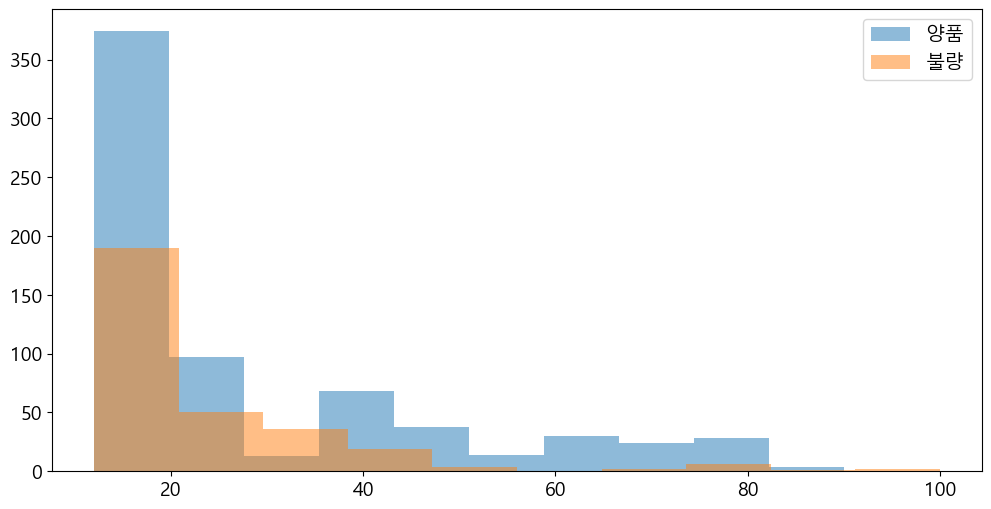

In [50]:
def fun_plot_hist(data, var):
    plt.hist(data[data["scale"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["scale"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.legend()
fun_plot_hist(df, "pt_thick")

- 지시 두께는 25~35에서 불량이 많이 발생함

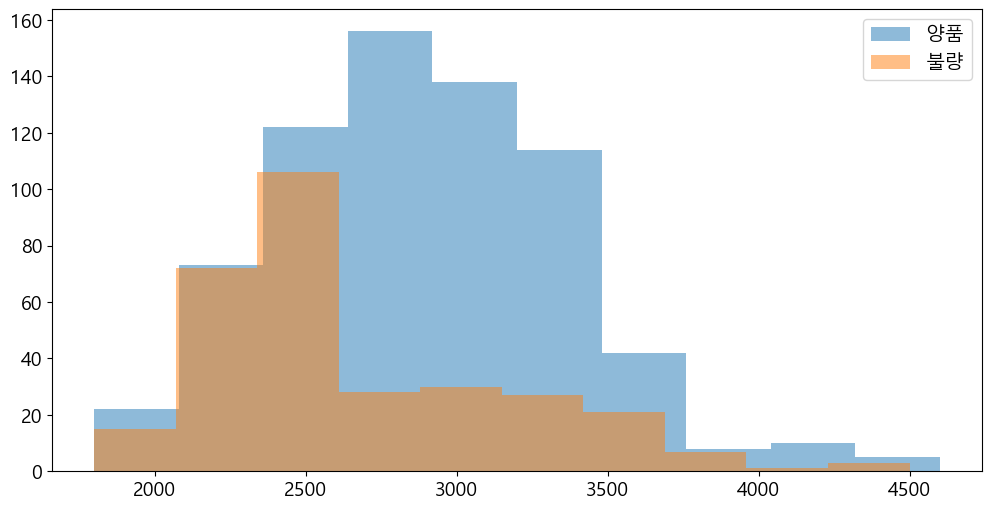

In [51]:
def fun_plot_hist(data, var):
    plt.hist(data[data["scale"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["scale"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.legend()
fun_plot_hist(df, "pt_width")

- 지시 너비는 2000~2500에서 불량이 많이 발생함

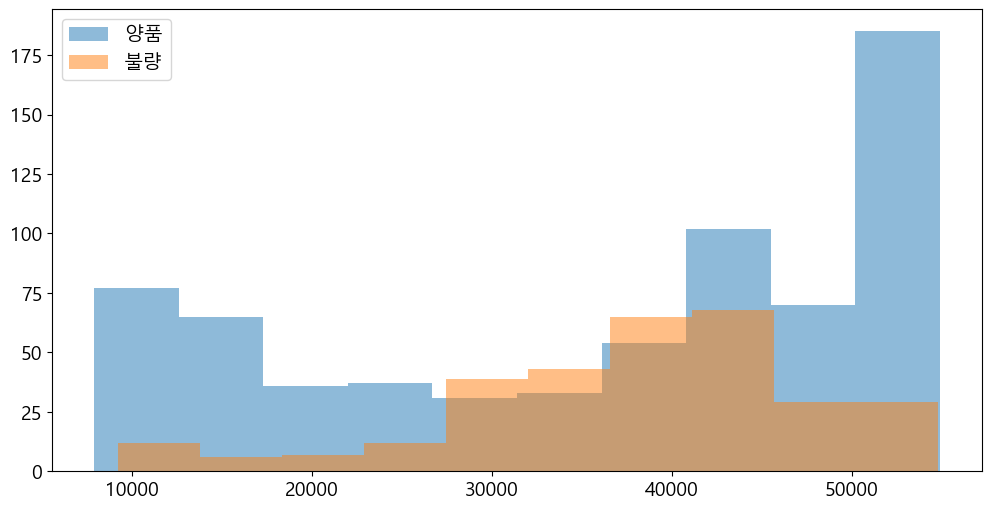

In [52]:
def fun_plot_hist(data, var):
    plt.hist(data[data["scale"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["scale"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.legend()
fun_plot_hist(df, "pt_length")

- 지시 길이는 30000~40000에서 불량이 많이 발생함

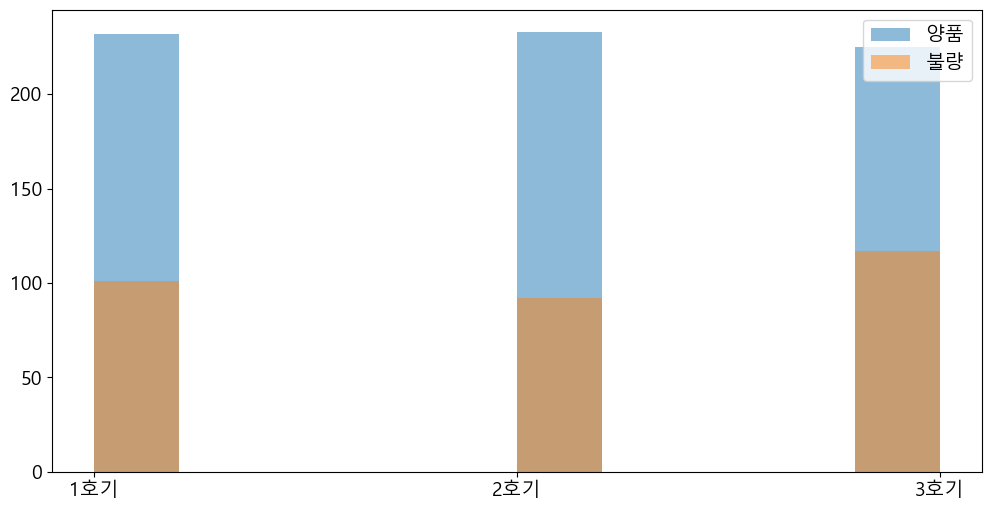

In [53]:
def fun_plot_hist(data, var):
    plt.hist(data[data["scale"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["scale"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.legend()
fun_plot_hist(df, "fur_no")

- 3호기에서 불량이 많이 발생함

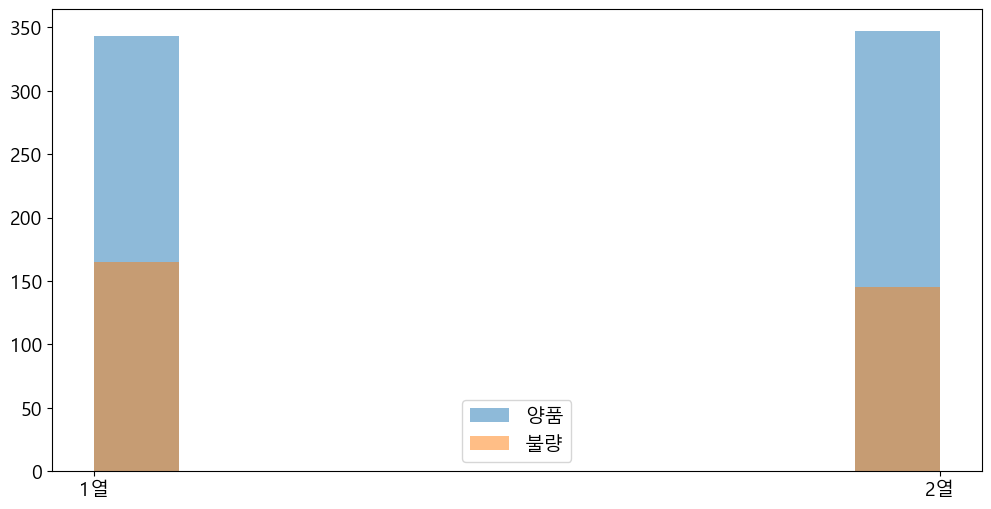

In [54]:
def fun_plot_hist(data, var):
    plt.hist(data[data["scale"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["scale"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.legend()
fun_plot_hist(df, "fur_input_row")

- 1열에서 불량이 많이 발생함

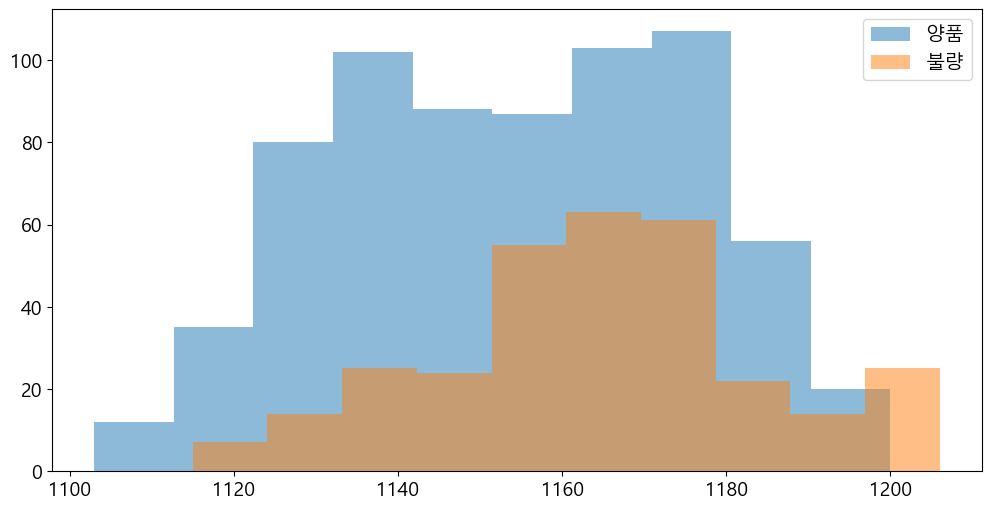

In [55]:
def fun_plot_hist(data, var):
    plt.hist(data[data["scale"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["scale"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.legend()
fun_plot_hist(df, "fur_heat_temp")

- 1160~1170, 1200이상일수록 가열대 온도에서 불량이 많이 발생함

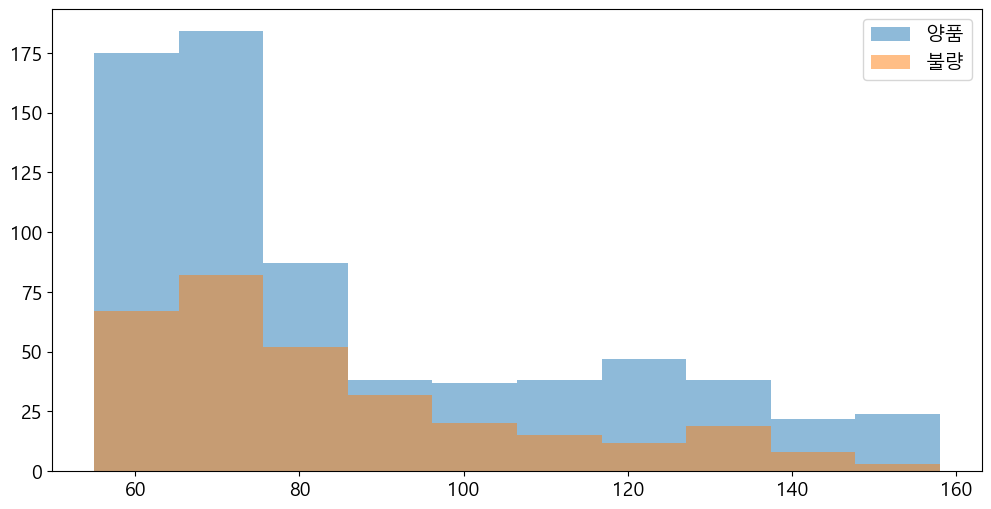

In [56]:
def fun_plot_hist(data, var):
    plt.hist(data[data["scale"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["scale"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.legend()
fun_plot_hist(df, "fur_heat_time")

- 가열대 재로시간은 60~80에서 불량이 발생하는데, 양품률이 더 많기 때문에 전체적으로 불량의 비율이 크지 않은 것을 알 수 있다.

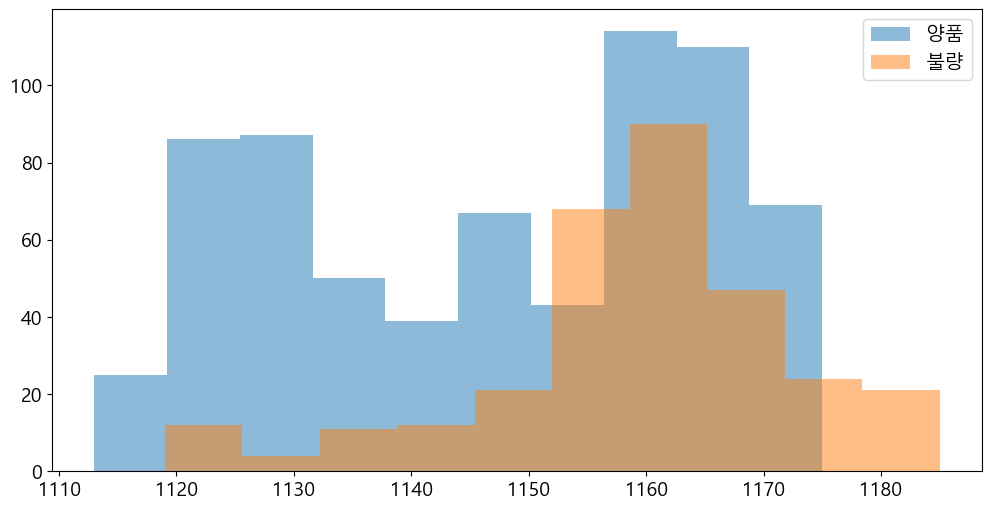

In [57]:
def fun_plot_hist(data, var):
    plt.hist(data[data["scale"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["scale"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.legend()
fun_plot_hist(df, "fur_soak_temp")

- 균열대 온도는 1155-1160, 1175이상에서 불량이 많이 발생함을 알 수 있다.

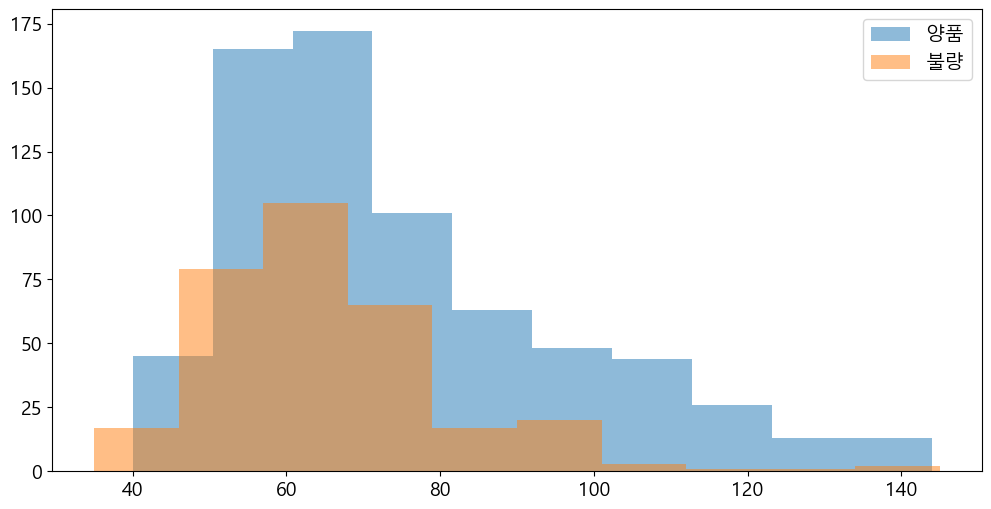

In [58]:
def fun_plot_hist(data, var):
    plt.hist(data[data["scale"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["scale"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.legend()
fun_plot_hist(df, "fur_soak_time")

- 균열대 재로 시간은 40 이하와 50에서 불량이 발생한다.

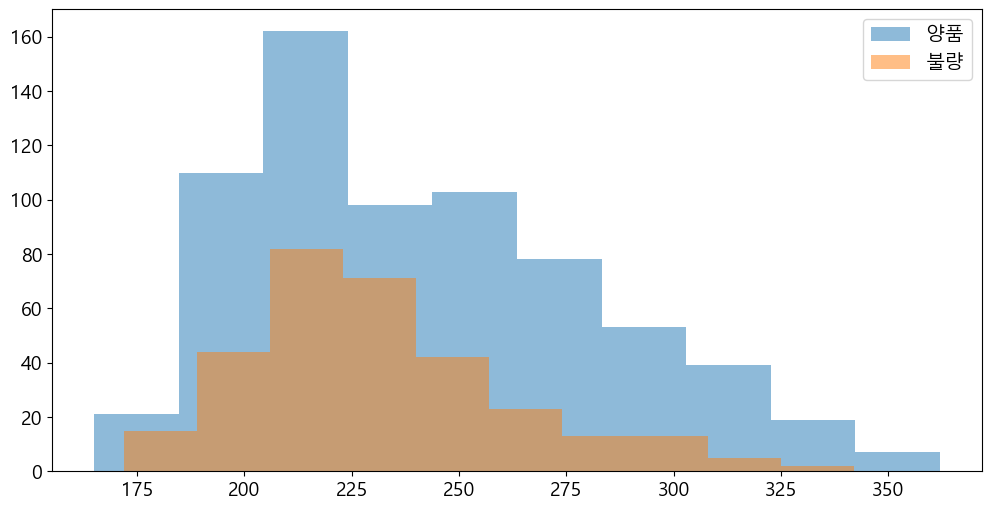

In [59]:
def fun_plot_hist(data, var):
    plt.hist(data[data["scale"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["scale"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.legend()
fun_plot_hist(df, "fur_total_time")

- 총 재로 시간은 175~200, 225~230에서 불량이 발생하지만 큰 불량은 보이지 않다고 판단하였음

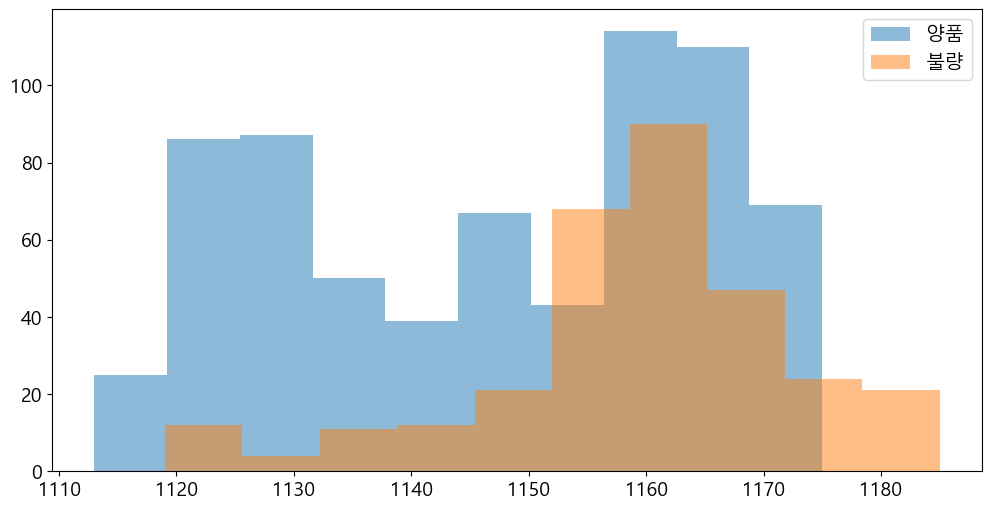

In [60]:
def fun_plot_hist(data, var):
    plt.hist(data[data["scale"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["scale"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.legend()
fun_plot_hist(df, "fur_ex_temp")

- 가열대 추출온도는 1155~1165에서 불량이 발생함을 알 수 있다.

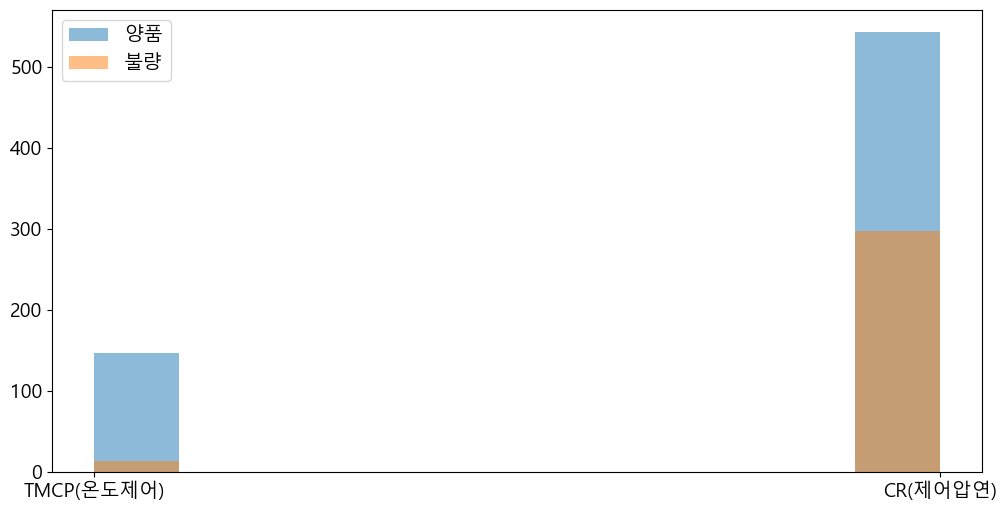

In [61]:
def fun_plot_hist(data, var):
    plt.hist(data[data["scale"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["scale"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.legend()
fun_plot_hist(df, "rolling_method")

- 압연방법은 제어압연에서 불량이 많이 나오는 것으로 보아, 제어압연이 불량률을 감소시키는 데 요인이 될 수 있다고 판단하였음

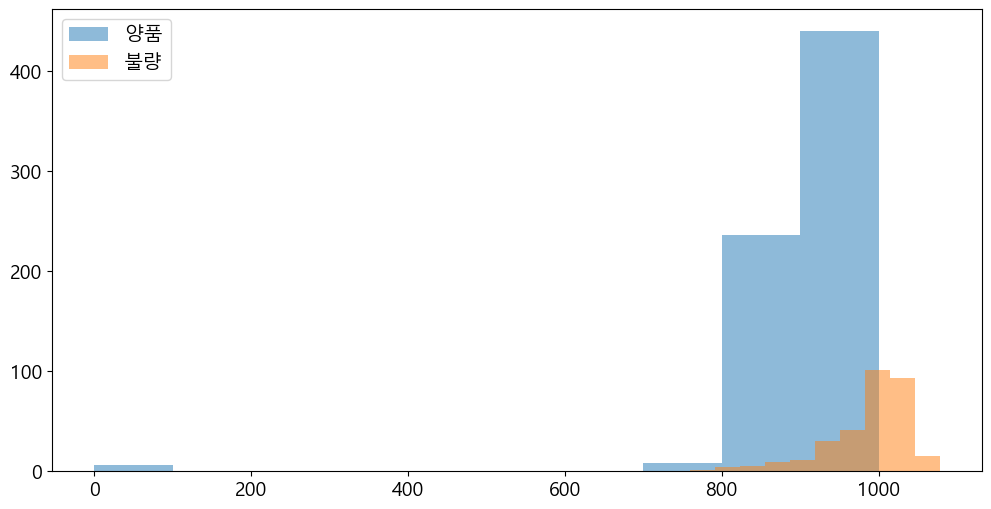

In [62]:
def fun_plot_hist(data, var):
    plt.hist(data[data["scale"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["scale"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.legend()
fun_plot_hist(df, "rolling_temp")

- 압연온도는 1000이상일 때 불량이 발생함을 알 수 있다.

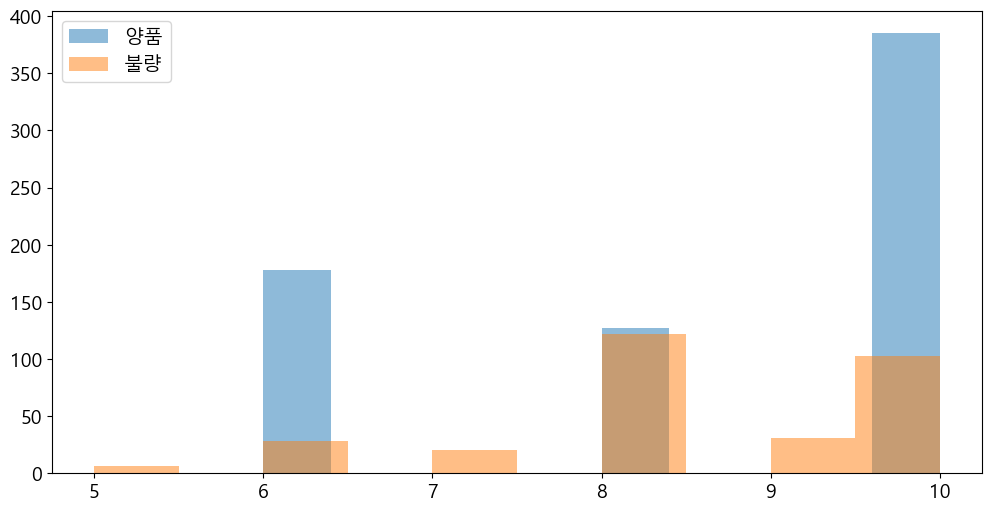

In [63]:
def fun_plot_hist(data, var):
    plt.hist(data[data["scale"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["scale"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.legend()
fun_plot_hist(df, "descaling_count")

- 압연횟수는 7, 9회일 때 불량률이 100%이다.

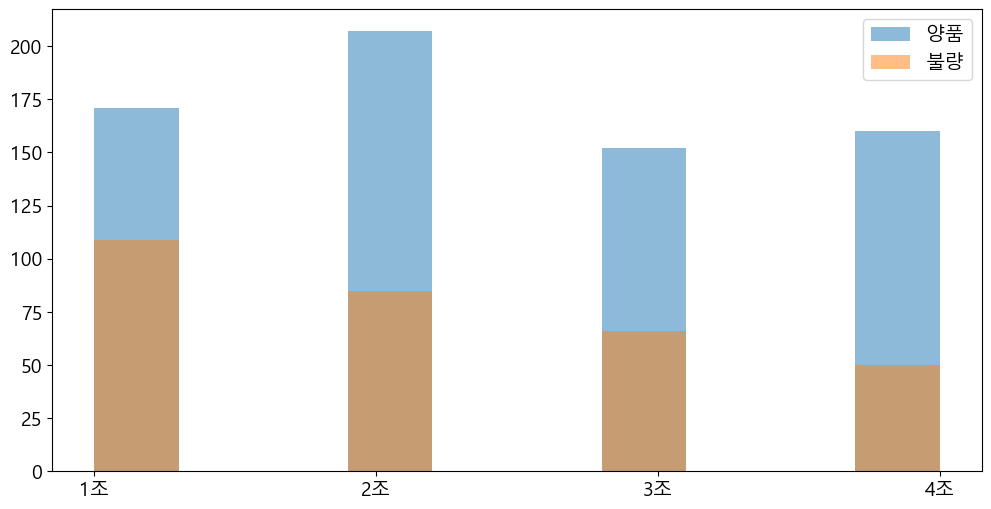

In [64]:
def fun_plot_hist(data, var):

    plt.hist(data[data["scale"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["scale"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.legend()
fun_plot_hist(df, "work_group")

- 1조와 3조에서 불량이 많이 보임

# 데이터 정제

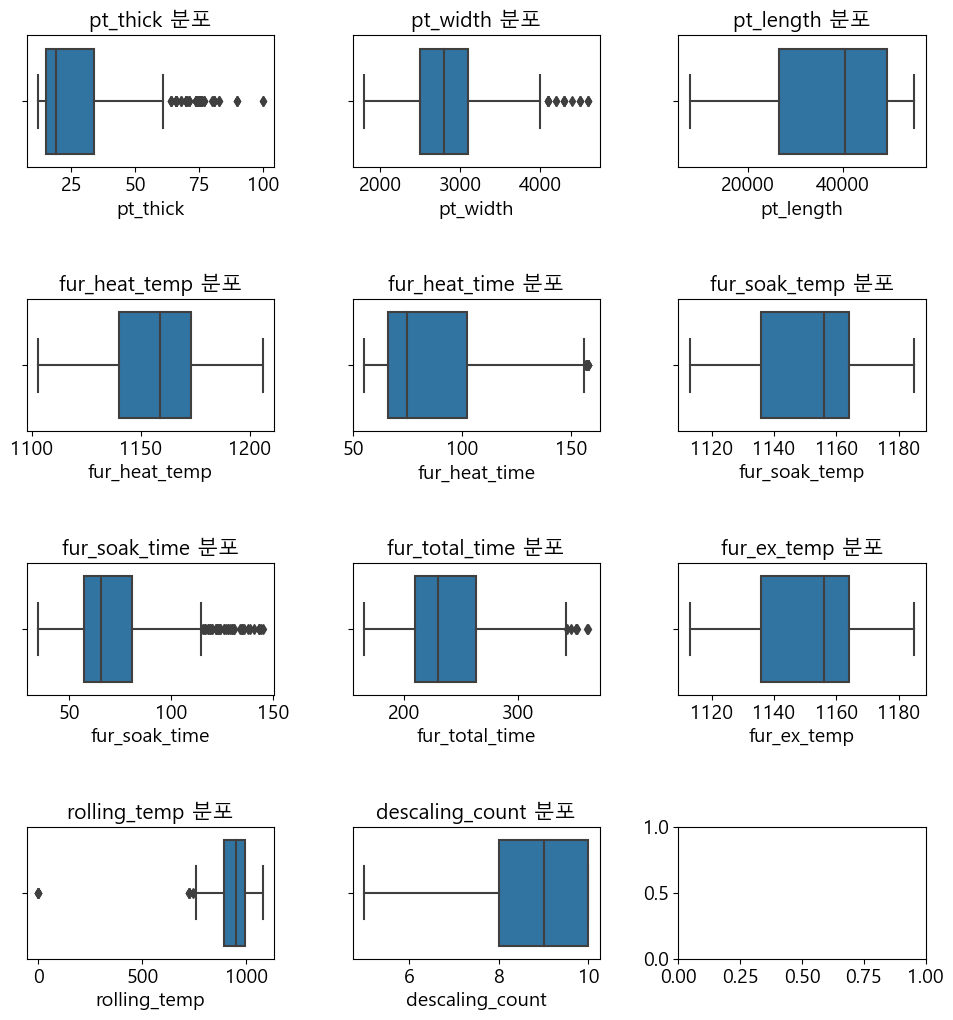

In [65]:
### 연속형 변수에서의 boxplot을 통한 이상치 확인
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10,10))
plt.tight_layout(w_pad=1, h_pad=5)
i = 1
for col in df.describe().columns.tolist():
    plt.subplot(4, 3, i) 
    sns.boxplot(data=df, x=col)
    plt.title(col + " 분포", fontsize=15)
    i += 1

In [66]:
# 압연온도가 0인 행 조회

df.query('rolling_temp == 0')

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group,교대,spec_name,호열
53,PLT_1054,03JAN2023:16:22:29,양품,GL-E36-TM,독일,T,56,3800,11400,적용,...,80,244,1128,TMCP(온도제어),0,6,1조,1교대,GL,3호기2열
221,PLT_1222,04JAN2023:19:44:09,양품,JS-SM490YB,일본,C,16,2200,43600,적용,...,67,228,1166,CR(제어압연),0,10,2조,2교대,JS,3호기2열
222,PLT_1223,04JAN2023:19:56:39,양품,JS-SM490YB,일본,C,16,2200,43600,적용,...,61,188,1164,CR(제어압연),0,10,2조,2교대,JS,3호기1열
598,PLT_1599,07JAN2023:11:40:51,양품,PILAC-BT33,한국,T,81,2100,12900,적용,...,59,229,1122,CR(제어압연),0,6,3조,1교대,PILAC,2호기1열
599,PLT_1600,07JAN2023:11:52:00,양품,PILAC-BT33,한국,T,81,2100,13200,적용,...,61,210,1124,CR(제어압연),0,6,3조,1교대,PILAC,1호기2열
600,PLT_1601,07JAN2023:11:59:10,양품,NV-D32-TM,영국,T,40,2500,23600,적용,...,76,260,1117,TMCP(온도제어),0,6,3조,1교대,NV,3호기1열


In [67]:
idx = df.query('rolling_temp == 0').index

df.loc[idx, 'rolling_temp'] = df['rolling_temp'].mean()

- 압연온도 0인 이상치 평균으로 대체

In [68]:
df['scale'] = np.where(df['scale'] == "불량", 1, 0)
df['scale'].value_counts()

0    690
1    310
Name: scale, dtype: int64

In [69]:
# 필요없는 컬럼 제거

df.drop(['rolling_date', 'plate_no'], axis = 1, inplace = True)
df.columns

Index(['scale', 'spec_long', 'spec_country', 'steel_kind', 'pt_thick',
       'pt_width', 'pt_length', 'hsb', 'fur_no', 'fur_input_row',
       'fur_heat_temp', 'fur_heat_time', 'fur_soak_temp', 'fur_soak_time',
       'fur_total_time', 'fur_ex_temp', 'rolling_method', 'rolling_temp',
       'descaling_count', 'work_group', '교대', 'spec_name', '호열'],
      dtype='object')

#### 데이터 분리

In [70]:
# 모델 학습을 위한 데이터 분리
df
df_x = df.drop(["scale"], axis = 1, inplace = False) # 설명 변수 
df_y = df["scale"] # 목표 변수

print(df_x.shape)
print(df_y.shape)

(1000, 22)
(1000,)


In [71]:
# 명목형 변수 분류
df_object = df_x.select_dtypes(include = 'object')
obj_cols = df_object.columns
obj_cols

Index(['spec_long', 'spec_country', 'steel_kind', 'hsb', 'fur_no',
       'fur_input_row', 'rolling_method', 'work_group', '교대', 'spec_name',
       '호열'],
      dtype='object')

In [72]:
# 수치형 변수 분류
df_numeric = df_x.select_dtypes(exclude = 'object')
num_cols = df_numeric.columns
num_cols

Index(['pt_thick', 'pt_width', 'pt_length', 'fur_heat_temp', 'fur_heat_time',
       'fur_soak_temp', 'fur_soak_time', 'fur_total_time', 'fur_ex_temp',
       'rolling_temp', 'descaling_count'],
      dtype='object')

In [73]:
# 수치형 변수 스케일링

scaler = StandardScaler()
scaler.fit(df_numeric)
df_numeric = scaler.transform(df_numeric)
df1 = pd.DataFrame(df_numeric, columns = num_cols)
df1
df2 = pd.DataFrame(df_object)
df2
df_scaled = pd.concat([df1, df2], axis=1)
df_scaled = pd.concat([df_scaled, df_y], axis=1)
df_scaled.head()

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_temp,...,steel_kind,hsb,fur_no,fur_input_row,rolling_method,work_group,교대,spec_name,호열,scale
0,0.287834,1.757877,-1.559693,-0.623753,1.140313,-1.034166,-0.617721,0.534659,-1.034166,-0.098139,...,T,적용,1호기,1열,TMCP(온도제어),1조,1교대,AB/EH32,1호기1열,0
1,0.287834,1.757877,-1.559693,-0.623753,1.368163,-0.918797,-0.909098,-0.015429,-0.918797,-0.050993,...,T,적용,1호기,2열,TMCP(온도제어),1조,1교대,AB/EH32,1호기2열,0
2,0.342996,1.555380,-1.264844,-1.330154,1.140313,-1.726379,-0.811972,0.508464,-1.726379,-0.805322,...,T,적용,2호기,1열,TMCP(온도제어),1조,1교대,NV,2호기1열,0
3,0.342996,1.555380,-1.264844,-0.247005,1.482088,-1.380272,-0.180654,0.718022,-1.380272,-0.868183,...,T,적용,2호기,2열,TMCP(온도제어),1조,1교대,NV,2호기2열,0
4,0.618805,0.542895,-1.689139,-0.812126,1.823863,-1.322588,-1.151913,0.194129,-1.322588,-1.056765,...,T,적용,3호기,1열,TMCP(온도제어),1조,1교대,BV,3호기1열,0


In [74]:
df_scaled['scale'].value_counts()

0    690
1    310
Name: scale, dtype: int64

#### 다중공선성

- VIF 10 이상인 변수 제거

In [75]:
df_scaled = df_scaled.reset_index(drop=True)
df_scaled_x = df_scaled.drop(["scale"], axis = 1, inplace = False) # 설명 변수 
df_scaled_y = df_scaled["scale"] # 목표 변수

In [76]:
df_numeric = df_scaled_x.select_dtypes(exclude = 'object')
num_cols = df_numeric.columns
num_cols

Index(['pt_thick', 'pt_width', 'pt_length', 'fur_heat_temp', 'fur_heat_time',
       'fur_soak_temp', 'fur_soak_time', 'fur_total_time', 'fur_ex_temp',
       'rolling_temp', 'descaling_count'],
      dtype='object')

In [77]:
df_object = df_scaled_x.select_dtypes(include = 'object')
obj_cols = df_object.columns
obj_cols

Index(['spec_long', 'spec_country', 'steel_kind', 'hsb', 'fur_no',
       'fur_input_row', 'rolling_method', 'work_group', '교대', 'spec_name',
       '호열'],
      dtype='object')

In [78]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_numeric.values, i) for i in range(df_numeric.shape[1])]
vif["features"] = df_numeric.columns
vif

,VIF Factor,features
0,6.885487,pt_thick
1,1.592550,pt_width
2,5.380123,pt_length
3,3.293434,fur_heat_temp
4,4.257072,fur_heat_time
5,inf,fur_soak_temp
6,3.809385,fur_soak_time
7,6.539282,fur_total_time
8,inf,fur_ex_temp
9,2.586890,rolling_temp


- VIF가 10이 넘어 inf인 fur_soak_temp(균열대 소재온도), fur_ex_temp(가열로 추출온도) 변수들은 제거할 예정


- 가열로 추출온도가 계산치이기 때문에 정확한 값이 아니라고 판단하여 먼저 제거를 진행

In [79]:
# 가열로 추출온도 제거

df_numeric_EXTEMP = df_numeric.drop(["fur_ex_temp"], axis = 1, inplace = False)

vif_EXTEMP = pd.DataFrame()
vif_EXTEMP["VIF Factor"] = [variance_inflation_factor(df_numeric_EXTEMP.values, i) for i in range(df_numeric_EXTEMP.shape[1])]
vif_EXTEMP["features"] = df_numeric_EXTEMP.columns
vif_EXTEMP

,VIF Factor,features
0,6.885487,pt_thick
1,1.592550,pt_width
2,5.380123,pt_length
3,3.293434,fur_heat_temp
4,4.257072,fur_heat_time
5,7.594804,fur_soak_temp
6,3.809385,fur_soak_time
7,6.539282,fur_total_time
8,2.586890,rolling_temp
9,4.551073,descaling_count


In [80]:
# 가열로 균열대 소재온도 제거

df_numeric_sz = df_numeric.drop(["fur_soak_temp"], axis = 1, inplace = False)

vif_SZ = pd.DataFrame()
vif_SZ["VIF Factor"] = [variance_inflation_factor(df_numeric_sz.values, i) for i in range(df_numeric_sz.shape[1])]
vif_SZ["features"] = df_numeric_sz.columns
vif_SZ

,VIF Factor,features
0,6.885487,pt_thick
1,1.592550,pt_width
2,5.380123,pt_length
3,3.293434,fur_heat_temp
4,4.257072,fur_heat_time
5,3.809385,fur_soak_time
6,6.539282,fur_total_time
7,7.594804,fur_ex_temp
8,2.586890,rolling_temp
9,4.551073,descaling_count


- 상관관계가 높은 가열로 균열대 온도(fur_soak_temp)와 추출 온도(fur_ex_temp)를 각각 제거했을때 모든 변수의 VIF는 같으면서 처음과 달리 줄어듦


- 따라서 두 변수 중 아무 변수나 삭제 할 수 있다는 것을 의미하고 여기서는 가열로 추출온도(fur_ex_temp)를 제거


- VIF가 더이상 10보다 큰 변수가 존재하지 않아 변수 제거 X

In [81]:
df_scaled.drop(["fur_ex_temp"], axis = 1, inplace = True)
df_scaled_x.drop(["fur_ex_temp"], axis = 1, inplace = True)
df_scaled.columns

Index(['pt_thick', 'pt_width', 'pt_length', 'fur_heat_temp', 'fur_heat_time',
       'fur_soak_temp', 'fur_soak_time', 'fur_total_time', 'rolling_temp',
       'descaling_count', 'spec_long', 'spec_country', 'steel_kind', 'hsb',
       'fur_no', 'fur_input_row', 'rolling_method', 'work_group', '교대',
       'spec_name', '호열', 'scale'],
      dtype='object')

In [82]:
df['spec_long'].unique()

# 선급협회 / 

array(['AB/EH32-TM', 'NV-E36-TM', 'BV-EH36-TM', 'AB/EH36-TM', 'COMMON',
       'BV-AH32-TM', 'GL-E32-TM', 'GL-E36-TM', 'BV-EH32-TM', 'KS-HSB600',
       'LR-EH36-TM', 'BV-B', 'AB/B', 'LR-B', 'JS-SM490YB', 'KR-B', 'LR-A',
       'JS-SM490A', 'KS-SM400B', 'JS-SM400B', 'KS-SS400', 'KR-A',
       'JS-SS400', 'NV-A', 'KS-SM400A', 'KS-SM490B', 'V42JBN3', 'AB/A',
       'A516-60', 'BV-AH32', 'JS-SM490YA', 'AB/AH32', 'GL-A32', 'LR-AH32',
       'CCS-B', 'NV-B', 'NV-A32', 'KS-SM490A', 'GL-A', 'NK-KA32',
       'LR-AH36', 'A709-36', 'KR-AH32', 'BV-A', 'NK-KA', 'NV-D36-TM',
       'NK-KA32-TM', 'GL-A32-TM', 'LR-AH36-TM', 'LR-EH32-TM', 'NV-E32-TM',
       'KS-HSB500', 'API-2W-50T', 'GL-A36-TM', 'NV-A32-TM', 'NV-D32-TM',
       'NK-KD36-TM', 'GL-D36-TM', 'PILAC-BT33', 'NV-A36-TM', 'BV-AH36-TM',
       'A131-DH36TM', 'BV-AH36-TL', 'SA283-C', 'A283-C', 'JS-SM400A'],
      dtype=object)

#### Vital Few 탐색

In [83]:
# 더미화 수행

df_dummy_x = pd.get_dummies(df_scaled_x)
df_dummy_x.head()

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,...,spec_name_NV,spec_name_PILAC,spec_name_SA283,spec_name_V42JBN3,호열_1호기1열,호열_1호기2열,호열_2호기1열,호열_2호기2열,호열_3호기1열,호열_3호기2열
0,0.287834,1.757877,-1.559693,-0.623753,1.140313,-1.034166,-0.617721,0.534659,-0.098139,-0.347396,...,0,0,0,0,1,0,0,0,0,0
1,0.287834,1.757877,-1.559693,-0.623753,1.368163,-0.918797,-0.909098,-0.015429,-0.050993,-0.347396,...,0,0,0,0,0,1,0,0,0,0
2,0.342996,1.555380,-1.264844,-1.330154,1.140313,-1.726379,-0.811972,0.508464,-0.805322,-0.347396,...,1,0,0,0,0,0,1,0,0,0
3,0.342996,1.555380,-1.264844,-0.247005,1.482088,-1.380272,-0.180654,0.718022,-0.868183,-0.347396,...,1,0,0,0,0,0,0,1,0,0
4,0.618805,0.542895,-1.689139,-0.812126,1.823863,-1.322588,-1.151913,0.194129,-1.056765,-0.347396,...,0,0,0,0,0,0,0,0,1,0


In [84]:
dt_base = DecisionTreeClassifier()
train_x, test_x, train_y, test_y = train_test_split(df_dummy_x, df_scaled_y, test_size=0.3)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape, )

(700, 129) (300, 129) (700,) (300,)


In [85]:
dt_base.fit(train_x, train_y)
df_importance = pd.DataFrame()
df_importance['Feature'] = test_x.columns
df_importance['Importance'] = dt_base.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
8,rolling_temp,0.521
86,hsb_적용,0.170
5,fur_soak_temp,0.156
0,pt_thick,0.106
9,descaling_count,0.026
...,...,...
42,spec_long_JS-SS400,0.000
41,spec_long_JS-SM490YB,0.000
40,spec_long_JS-SM490YA,0.000
39,spec_long_JS-SM490A,0.000


Text(0, 0.5, '변수')

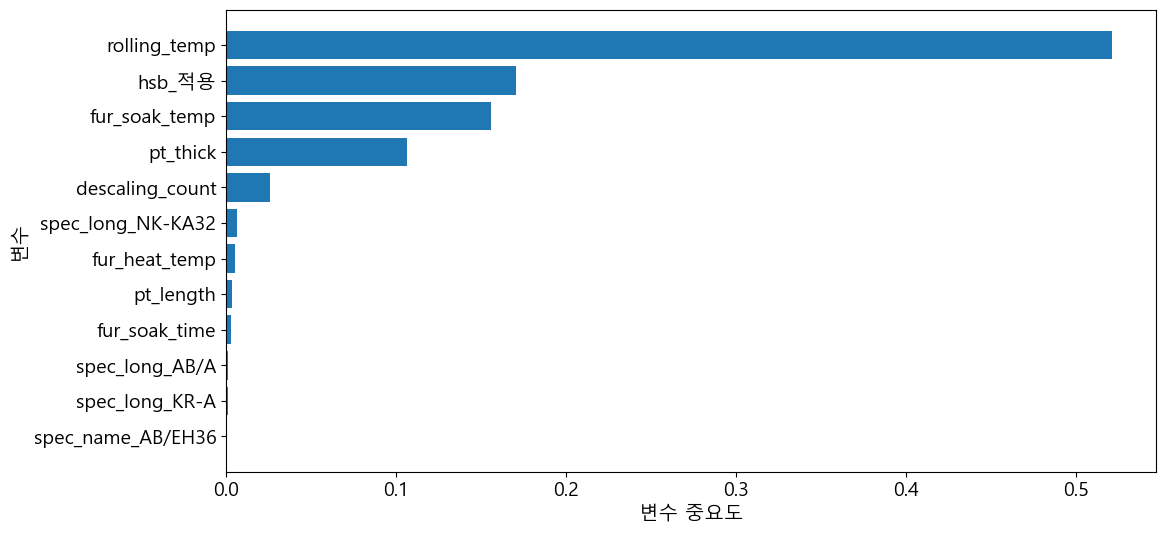

In [86]:
### 0인 값이 많기 때문에 해당 값들을 제거한 그래프만 확인
df_importance.sort_values("Importance", ascending=True, inplace=True)
df_importance = df_importance[df_importance.Importance > 0]
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

- Vital Few:


- rolling_temp, hsb_미적용, fur_soak_time, pt_thick, descaling_count 등이 불량 발생에 영향을 많이 주는 변수


- 스케일링의 적용 여부 및 횟수 내지 온도가 산화철 발생의 큰 영향을 끼침

# 모델링

###  Decision Tree

In [87]:
# Decision Tree 

dt_model = DecisionTreeClassifier()
dt_model.fit(train_x, train_y)

DecisionTreeClassifier()

In [88]:
# GridSearch

param_grid = {'max_depth': range(2, 10),
              'min_samples_split': range(2,40,2),
              'min_samples_leaf': range(2,20,2)}

grid_dt = GridSearchCV(dt_model, param_grid, cv = 3, n_jobs = -1)
grid_dt.fit(train_x, train_y)

print('best model: \n{}'.format(grid_dt.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_dt.best_params_))
print('\nbest score: \n{}'.format(grid_dt.best_score_.round(3)))
print('\nbest set score: \n{}'.format(grid_dt.score(test_x, test_y).round(3)))

best model: 
DecisionTreeClassifier(max_depth=6, min_samples_leaf=4)

best parameter: 
{'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2}

best score: 
0.989

best set score: 
0.97


In [89]:
# 최종 Decision Tree

tree_final = DecisionTreeClassifier(min_samples_leaf = 2, min_samples_split = 2, max_depth = 6, random_state = 1234)
tree_final.fit(train_x, train_y)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=2, random_state=1234)

In [90]:
# Train 데이터 설명력
print("Train data의 정확도: {:.3f}".format(tree_final.score(train_x, train_y).round(3)))
print("Test data의 정확도: {:.3f}".format(tree_final.score(test_x, test_y).round(3)))

Train data의 정확도: 0.993
Test data의 정확도: 0.983


In [91]:
# tree feature_importance로 설명변수 중요도 확인 및 데이터 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = train_x.columns
df_importance['Importance'] = tree_final.feature_importances_
df_importance.sort_values(by = 'Importance', ascending = False, inplace = True)
df_importance.head(10)

,Feature,Importance
8,rolling_temp,0.531925
86,hsb_적용,0.176013
5,fur_soak_temp,0.160953
9,descaling_count,0.131109
90,fur_input_row_1열,0.000000
84,steel_kind_T,0.000000
85,hsb_미적용,0.000000
87,fur_no_1호기,0.000000
88,fur_no_2호기,0.000000
89,fur_no_3호기,0.000000


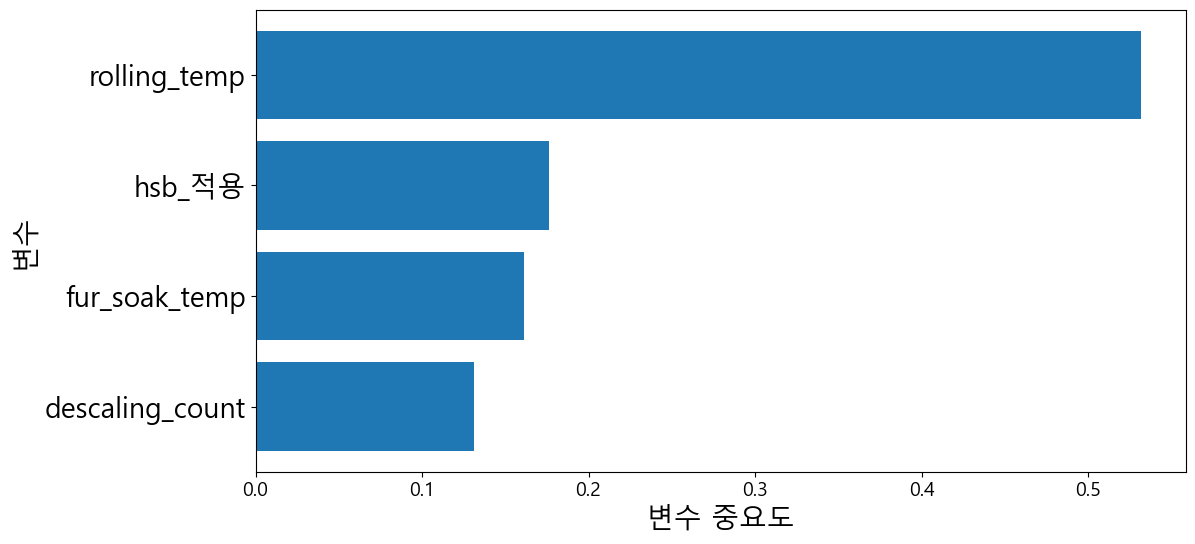

In [92]:
# 설명변수 중요도 그래프

df_importance.sort_values("Importance", ascending = True, inplace = True)
df_importance = df_importance[df_importance.Importance > 0]
coordinates = range(len(df_importance))
plt.barh( y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance['Feature'], size = 20)
plt.xlabel("변수 중요도", size = 20)
plt.ylabel("변수", size = 20)
plt.show()

### Random Forest

In [93]:
# Random Forest 모델 생성 및 학습
rf_model = RandomForestClassifier()


# GridSearchCV

param_grid = {'max_depth': range(2, 10),
              'min_samples_split': range(2,20,2),
              'min_samples_leaf': range(2,20,2)}
grid_rf = GridSearchCV(rf_model, param_grid, cv = 3, n_jobs = -1)
grid_rf.fit(train_x, train_y)

print('best model: \n{}'.format(grid_rf.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_rf.best_params_))
print('\nbest score: \n{}'.format(grid_rf.best_score_.round(3)))
print('\nbest set score: \n{}'.format(grid_rf.score(test_x, test_y).round(3)))

best model: 
RandomForestClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=14)

best parameter: 
{'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 14}

best score: 
0.949

best set score: 
0.937


In [94]:
# 최종 RandomForest

rf_final = RandomForestClassifier(min_samples_leaf = 2, min_samples_split = 16, max_depth = 9)
rf_final.fit(train_x, train_y)

RandomForestClassifier(max_depth=9, min_samples_leaf=2, min_samples_split=16)

In [95]:
# Train 데이터 설명력
print("Train data의 정확도: {:.3f}".format(rf_final.score(train_x, train_y).round(3)))
print("Test data의 정확도: {:.3f}".format(rf_final.score(test_x, test_y).round(3)))

Train data의 정확도: 0.966
Test data의 정확도: 0.933


In [96]:
# tree feature_importance로 설명변수 중요도 확인 및 데이터 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = train_x.columns
df_importance['Importance'] = rf_final.feature_importances_
df_importance.sort_values(by = 'Importance', ascending = False, inplace = True)
df_importance.head(10)

,Feature,Importance
8,rolling_temp,0.226888
5,fur_soak_temp,0.088382
1,pt_width,0.069264
86,hsb_적용,0.065347
85,hsb_미적용,0.062036
2,pt_length,0.057920
9,descaling_count,0.054997
3,fur_heat_temp,0.054513
0,pt_thick,0.050801
83,steel_kind_C,0.035180


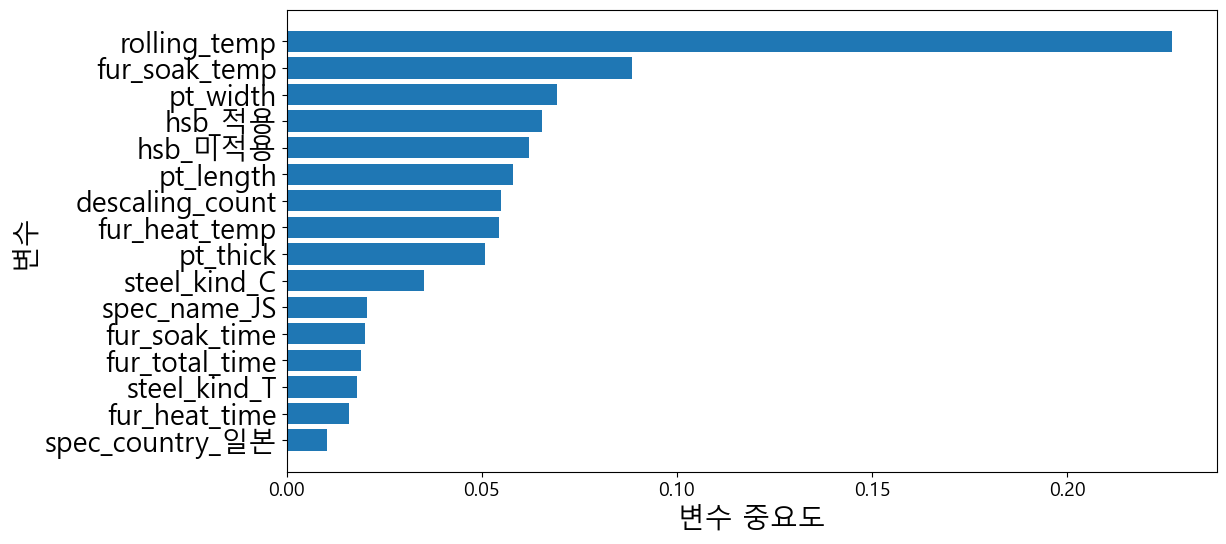

In [97]:
# 설명변수 중요도 그래프

df_importance.sort_values("Importance", ascending = True, inplace = True)
df_importance = df_importance[df_importance.Importance > 0.01]
coordinates = range(len(df_importance))
plt.barh( y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance['Feature'], size = 20)
plt.xlabel("변수 중요도", size = 20)
plt.ylabel("변수", size = 20)
plt.show()

### XGBOOST

In [98]:
# XGBOOST

estimator = XGBClassifier()
param_grid = {'n_estimators': [i*10 for i in range(1,16)], 'max_depth' : [i for i in range(1, 10)],
              'gamma' : [i for i in range(1,6)], 'learning_rate' : [i*0.1 for i in range(1,20)]}
xgb_model = RandomizedSearchCV(estimator, param_grid, n_jobs = -1)
xgb_model.fit(train_x, train_y)

print('Best parameters: ', xgb_model.best_params_)
print('Best score: ', xgb_model.best_score_)

Best parameters:  {'n_estimators': 130, 'max_depth': 2, 'learning_rate': 1.8, 'gamma': 3}
Best score:  0.9914285714285714


In [99]:
xgb_final = XGBClassifier(n_estimators = 60, learning_rate = 0.7, gamma = 1, max_depth = 5)
xgb_final.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.7, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=60, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [100]:
# 데이터 설명력
print("Train data의 정확도: {:.3f}".format(xgb_final.score(train_x, train_y).round(3)))
print("Test data의 정확도: {:.3f}".format(xgb_final.score(test_x, test_y).round(3)))

Train data의 정확도: 0.996
Test data의 정확도: 0.977


In [101]:
xgb_importance = pd.DataFrame()
xgb_importance['Feature'] = train_x.columns
xgb_importance['Importance'] = xgb_final.feature_importances_
xgb_importance.sort_values(by = 'Importance', ascending = False, inplace = True)
xgb_importance.head(10)

,Feature,Importance
8,rolling_temp,0.344305
85,hsb_미적용,0.191830
0,pt_thick,0.151532
5,fur_soak_temp,0.141064
2,pt_length,0.074801
6,fur_soak_time,0.017962
90,fur_input_row_1열,0.017623
9,descaling_count,0.017245
1,pt_width,0.015699
7,fur_total_time,0.014237


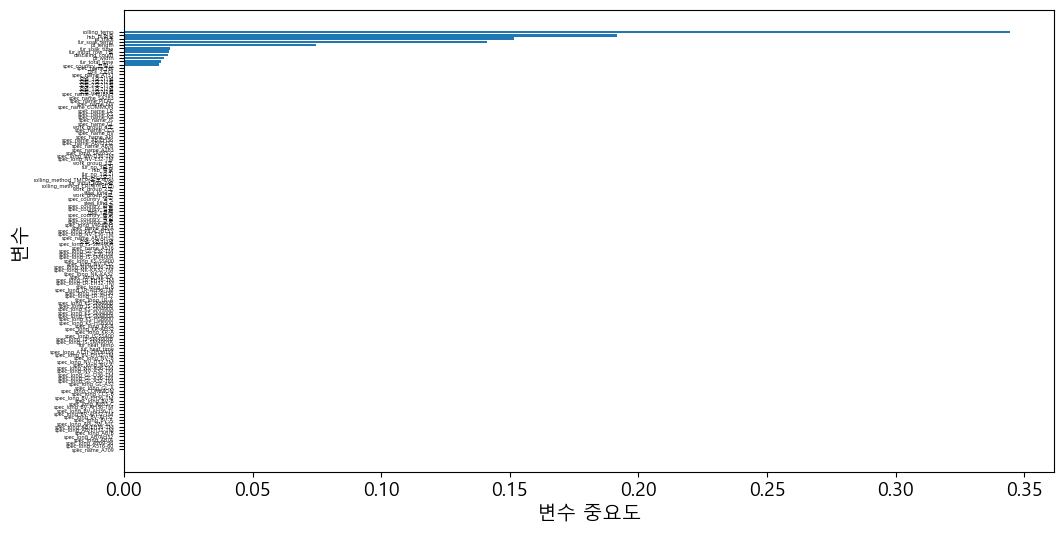

In [102]:
# 설명변수 중요도 그래프

xgb_importance.sort_values("Importance", ascending = True, inplace = True)
df_importance = df_importance[df_importance.Importance > 0.1]
coordinates = range(len(xgb_importance))
plt.barh( y = coordinates, width = xgb_importance["Importance"])
plt.yticks(coordinates, xgb_importance['Feature'], size = 4)
plt.xlabel("변수 중요도")
plt.ylabel("변수")
plt.show()

#### 정확도가 99.3%로 가장 높은 Decision Tree 모델을 최종 모델로 선정


#### 변수 중요도를 통해 rolling_temp, hsb_미적용, fur_soak_temp, pt_thick, descaling_point, pt_length를 VF로 선정


#### 단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있음

#### scale 발생을 줄이는 방법

- rolling_temp(압연온도)를 낮춘다.


- HSB(후판 공장에서 가열중 발생되는 1차 Scale 제거장치)를 적용한다.


- fur_soak_temp(추출온도)를 낮춘다.


- pt_thick(plate 두께)를 줄인다.


- descaling_point(압연 중 descaling 횟수)를 늘린다.


- pt_length(plath 길이)를 늘린다.